# **Volatility Skew Trading**

Volatility skew is a well-known phenomenon in the options market that refers to the difference in implied volatility (IV) between out-of-the-money (OTM) calls and puts. This skew arises from market sentiment, supply and demand imbalances, and behavioral factors — most notably loss aversion.

## Why Trade the Skew?

Options were originally introduced as hedging instruments, and many investors are willing to overpay for downside protection. This behavioral bias is well described by **Prospect Theory** (Kahneman & Tversky, 1979), which suggests that individuals tend to overweight small-probability events and exhibit strong aversion to losses.

As options traders, we can exploit these persistent mispricings by constructing volatility skew trading strategies, aiming to profit when market-implied fears (e.g., demand for puts) fail to materialize. These strategies typically assume that the pricing dislocation is temporary or exaggerated relative to actual realized outcomes.

The notebook is structured as follows:

1. [Read SPX Options Data](#read_data)
2. [Plot the Implied Volatility Skew](#plot_iv)
3. [Remove illiquid Options](#illiquid)
4. [Build the Synthetic 30-DTE Skew](#skew)
5. [Implement Trading Strategies](#construct-strategy)
   - [5.1. Trade Execution Setup](#trade-execution-setup)
   - [5.2 Strategy 1: Simple Mean Reversion on the Skew](#strategy1-mean-reversion)
       - [5.2.1 Signal 1: Fixed Absolute Skew Threshold](#signal-fixed-threshold)
       - [5.2.2 Signal 2: Rolling Z-Score of the Skew](#signal-zscore)
   - [5.3 Strategy 2: Mean Reversion with IV-Percentile, Skew Percentile and VIX Filter](#strategy2-filtered)
6. [Backtesting Framework with Walk-Forward Cross-Validation & Risk Controls](#backtest-walkforward)
7. [Conclusion](#conclusion)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from abc import ABC, abstractmethod
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid

import utility.plot_helpers as ph
from utility.data_processor_helpers import reshape_options_wide_to_long
from config.constants import OPTION_TYPES

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# **Read SPX Options Data**

In this notebook we are going to consider the entire options chain, namely all strikes and expiries for each date in the year 2023.

In [2]:
file = "data/intermediate/full_spx_options_2016_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_gamma", "p_gamma",
    "c_vega", "p_vega",
    "c_theta", "p_theta",
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file)
options

,underlying_last,expiry,dte,strike,strike_distance,strike_distance_pct,c_delta,p_delta,c_gamma,p_gamma,...,c_last,p_last,c_bid,p_bid,c_ask,p_ask,c_size_bid,p_size_bid,c_size_ask,p_size_ask
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2012.98,2016-01-08,4.0,300.0,1713.0,0.851,1.00000,-0.00052,0.00000,0.0,...,0.0,0.0,1702.90,0.0,1715.00,0.06,1.0,0.0,1.0,365.0
2016-01-04,2012.98,2016-01-08,4.0,400.0,1613.0,0.801,1.00000,-0.00047,0.00000,0.0,...,0.0,0.0,1602.99,0.0,1618.50,0.04,1.0,0.0,2.0,6365.0
2016-01-04,2012.98,2016-01-08,4.0,500.0,1513.0,0.752,1.00000,-0.00034,0.00000,0.0,...,0.0,0.0,1509.01,0.0,1514.80,0.05,100.0,0.0,100.0,2165.0
2016-01-04,2012.98,2016-01-08,4.0,600.0,1413.0,0.702,1.00000,-0.00033,0.00000,0.0,...,0.0,0.0,1402.91,0.0,1416.89,0.05,1.0,0.0,1.0,165.0
2016-01-04,2012.98,2016-01-08,4.0,700.0,1313.0,0.652,1.00000,-0.00057,0.00000,0.0,...,0.0,0.0,1302.90,0.0,1317.80,0.05,1.0,0.0,1.0,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,4772.17,2029-12-21,2184.0,7200.0,2427.8,0.509,0.29633,-1.00000,0.00012,0.0,...,0.0,0.0,286.80,1550.9,366.80,1630.90,5.0,5.0,5.0,5.0
2023-12-29,4772.17,2029-12-21,2184.0,7400.0,2627.8,0.551,0.27129,-1.00000,0.00010,0.0,...,0.0,0.0,245.40,1669.0,325.40,1749.00,5.0,5.0,5.0,5.0
2023-12-29,4772.17,2029-12-21,2184.0,7600.0,2827.8,0.593,0.24709,-1.00000,0.00014,0.0,...,0.0,0.0,208.70,1791.8,288.70,1871.80,5.0,5.0,5.0,5.0


# **Plot the Implied Volatility Skew**

We now examine how the implied volatility skew evolves as time to maturity decreases, focusing on the first EOM (End-of-Month) options contracts.

In [3]:
expiry = "2023-01-31"

eom_options = options[options["expiry"] == expiry].copy()
eom_options

,underlying_last,expiry,dte,strike,strike_distance,strike_distance_pct,c_delta,p_delta,c_gamma,p_gamma,...,c_last,p_last,c_bid,p_bid,c_ask,p_ask,c_size_bid,p_size_bid,c_size_ask,p_size_ask
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,4118.53,2023-01-31,183.0,1200.0,2918.5,0.709,1.00000,-0.00205,0.00000,0.00000,...,0.00,0.00,2903.5,1.20,2915.80,1.55,1.0,124.0,1.0,163.0
2022-08-01,4118.53,2023-01-31,183.0,1400.0,2718.5,0.660,1.00000,-0.00340,0.00000,-0.00003,...,0.00,0.00,2707.4,1.95,2719.60,2.25,1.0,124.0,1.0,133.0
2022-08-01,4118.53,2023-01-31,183.0,1600.0,2518.5,0.612,1.00000,-0.00494,0.00000,-0.00003,...,0.00,0.00,2511.6,3.00,2523.80,3.30,1.0,122.0,1.0,131.0
2022-08-01,4118.53,2023-01-31,183.0,1800.0,2318.5,0.563,1.00000,-0.00762,0.00000,-0.00003,...,0.00,0.00,2316.4,4.40,2328.50,4.80,1.0,121.0,1.0,160.0
2022-08-01,4118.53,2023-01-31,183.0,2000.0,2118.5,0.514,1.00000,-0.01209,0.00000,0.00000,...,0.00,0.00,2121.3,6.30,2133.40,6.70,1.0,119.0,1.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,4077.16,2023-01-31,0.0,5000.0,922.8,0.226,0.00045,-0.91977,0.00000,0.00001,...,0.03,967.80,0.0,920.70,0.05,929.20,0.0,30.0,999.0,30.0
2023-01-31,4077.16,2023-01-31,0.0,5100.0,1022.8,0.251,0.00000,-0.91545,0.00001,0.00005,...,0.15,0.00,0.0,1020.70,0.05,1029.20,0.0,30.0,321.0,30.0
2023-01-31,4077.16,2023-01-31,0.0,5200.0,1122.8,0.275,0.00063,-0.91219,0.00000,0.00004,...,0.65,0.00,0.0,1120.70,0.05,1129.20,0.0,30.0,273.0,30.0


In [4]:
def compute_iv_smile(options, dte, atm_strike_range=1000):
    options_red = options.loc[options["dte"] == dte].copy()

    atm_idx = (
        (options_red["strike"] - options_red["underlying_last"])
        .abs()
        .argmin()
    )
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[(
        (options_red['strike'] - options_red['atm_strike']).abs()
          <= atm_strike_range
    )]

    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv']) # ATM
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

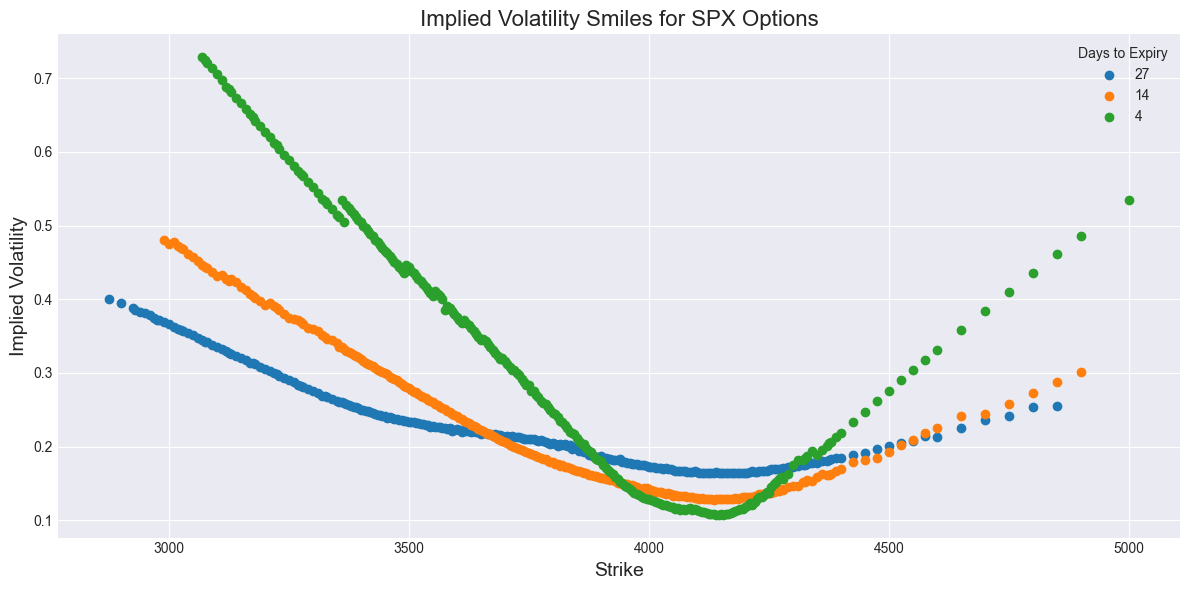

In [5]:
# Extract unique DTEs available
available_dtes = sorted(eom_options['dte'].unique())

# Extratc DTEs closest to 30, 15 and 1 resp.
dte_30 = max([d for d in available_dtes if d <= 30], default=None)
dte_15 = min(available_dtes, key=lambda x: abs(x - 15))
dte_1 = min([d for d in available_dtes if d > 1], default=None)

target_dtes = [int(d) for d in [dte_30, dte_15, dte_1] if d is not None]

iv_smiles = {}
for dte in target_dtes:
    iv_smile = compute_iv_smile(eom_options, dte)
    iv_smiles[dte] = iv_smile

ph.plot_iv_smiles(iv_smiles, "SPX")

For larger DTEs, the implied volatility skew takes the shape of a smirk, with moderately elevated IVs for OTM puts. As DTE approaches zero, the skew becomes much steeper, reflecting increased sensitivity to short-term downside risk.

# **Remove illiquid options**

To ensure more realistic and robust backtest results, we remove illiquid options. These contracts typically suffer from wide bid-ask spreads and poor fill quality, making them expensive to trade and potentially eroding any theoretical edge.

In [6]:
options = reshape_options_wide_to_long(options)
options.head()

,underlying_last,expiry,dte,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,size_bid,size_ask,option_type
date,,,,,,,,,,,,,,,,,,,
2016-01-04,2012.98,2016-12-16,347.0,100.0,1913.0,0.95,1.0,0.0,0.00000,0.00000,0.00000,NaN,0.0,0.0,1864.40,1870.81,12.0,9.0,C
2016-01-04,2012.98,2017-01-20,382.0,100.0,1913.0,0.95,1.0,0.0,0.00000,0.00000,0.00000,NaN,0.0,0.0,1861.50,1867.90,12.0,2.0,C
2016-01-04,2012.98,2017-12-15,711.0,100.0,1913.0,0.95,1.0,0.0,0.00000,0.00000,0.00000,NaN,0.0,0.0,1821.20,1832.20,10.0,12.0,C
2016-01-04,2012.98,2018-12-21,1082.0,100.0,1913.0,0.95,1.0,0.0,0.00000,0.00000,0.00000,NaN,0.0,0.0,1776.90,1792.10,1.0,1.0,C
2016-01-04,2012.98,2016-12-16,347.0,100.0,1913.0,0.95,0.0,0.0,0.00988,-0.00157,-0.00337,0.96207,50.0,0.1,0.06,0.10,20.0,290.0,P


## Volume Filter

Since Open Interest is not available in our dataset, we use daily traded **volume** as a proxy for option contract liquidity. While not a perfect substitute, volume provides a reasonable indication of market activity and tradability. 

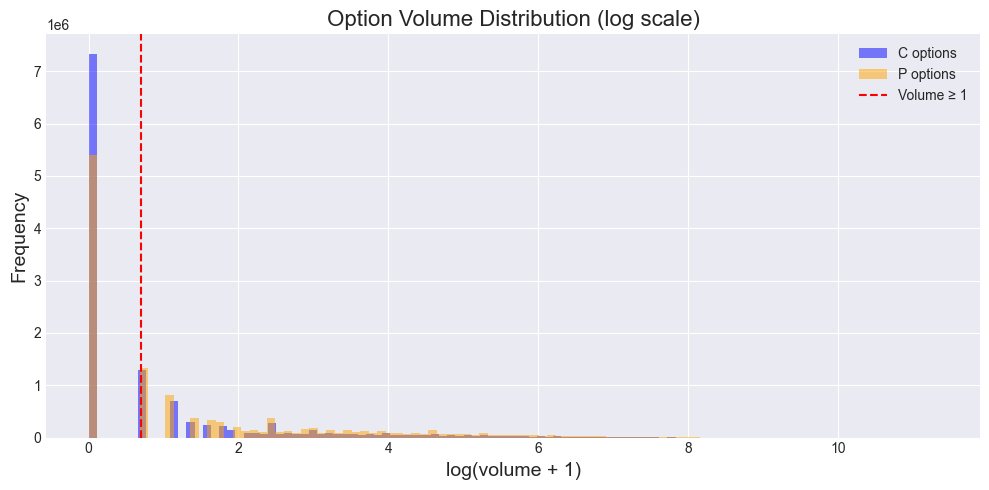

In [7]:
# Add 1 to avoid log(0), then take log
log_volumes = (options["volume"] + 1).apply(np.log)
ph.plot_volume_filter(options, log_volumes)

We remove options with very low volume (e.g., volume < 1), as these are likely illiquid and may not reflect reliable pricing or realistic execution.

In [8]:
volume_threshold = 1

## Bid-Ask Spread Filter

The bid-ask spread is a key measure of transaction cost and liquidity. Options with wide spreads are harder to trade efficiently and may reflect stale or unreliable pricing.

First we drop 0 ask and bid values, as they indicate that no trading occured at a particular date for a specific option.


Now we filter out options where the **relative bid-ask spread** exceeds a threshold (e.g., 25%), defined as:

$$
\text{Relative Spread} = \frac{\text{Ask} - \text{Bid}}{0.5 \times (\text{Ask} + \text{Bid})}
$$

In [9]:
options["mid"] = 0.5 * (options["bid"] + options["ask"])
options["rel_spread"] = (
    (options["ask"] - options["bid"]) / options["mid"]
)
options[["bid", "ask", "mid", "rel_spread"]]

,bid,ask,mid,rel_spread
date,,,,
2016-01-04,1864.40,1870.81,1867.605,0.003432
2016-01-04,1861.50,1867.90,1864.700,0.003432
2016-01-04,1821.20,1832.20,1826.700,0.006022
2016-01-04,1776.90,1792.10,1784.500,0.008518
2016-01-04,0.06,0.10,0.080,0.500000
...,...,...,...,...
2023-12-29,3.50,13.00,8.250,1.151515
2023-12-29,6348.40,6435.30,6391.850,0.013595
2023-12-29,6033.50,6087.70,6060.600,0.008943


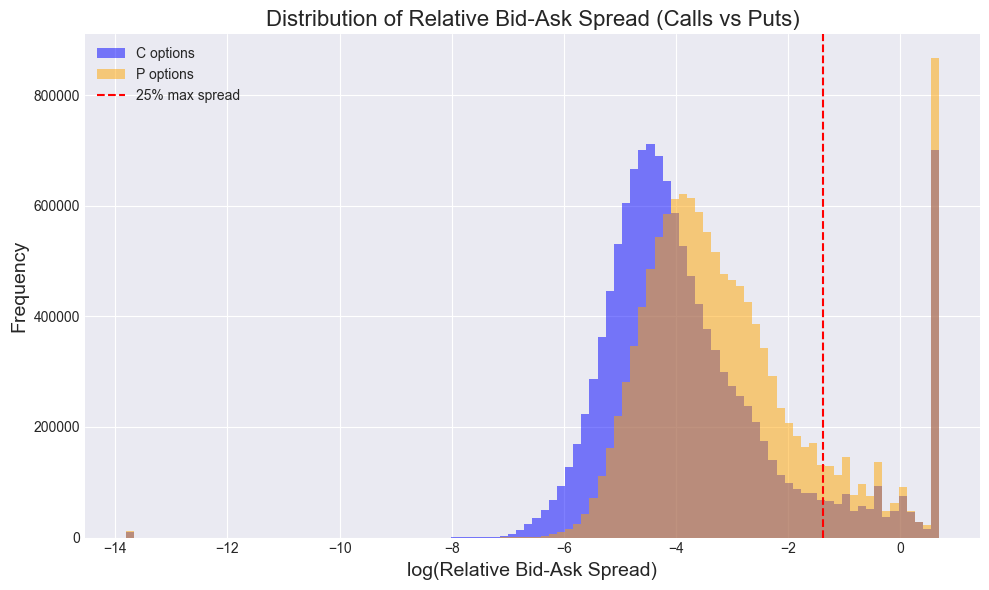

In [10]:
ph.plot_bid_ask_filter(options)

A threshold of 25% seems a reasonble choice for removing too large bid-ask spreads.

In [11]:
spread_threshold = 0.25

## Moneyness filter

We filter options based on their moneyness (strike / underlying price) to focus on contracts with meaningful market activity. Deep ITM or far OTM options are often illiquid or mispriced, so we retain only those within a reasonable band (e.g., 0.8 to 1.2).

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_20198/3178138296.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  options.groupby(["option_type", "moneyness_bin"])["volume"]


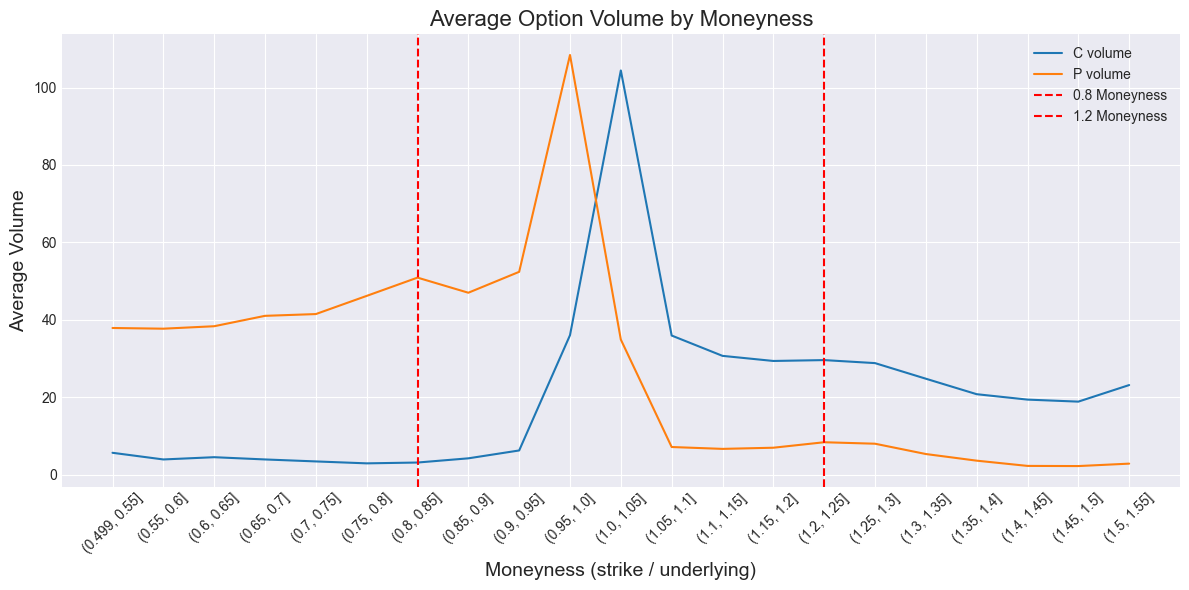

In [12]:
options["moneyness"] = options["strike"] / options["underlying_last"]

options["moneyness_bin"] = pd.cut(
    options["moneyness"],
    bins=np.arange(0.5, 1.6, 0.05),
    include_lowest=True
)

avg_vol = (
    options.groupby(["option_type", "moneyness_bin"])["volume"]
    .mean()
    .reset_index()
)

ph.plot_moneyness_filter(avg_vol)

We observe that average volume for OTM Calls drops sharply beyond a moneyness of 1.2, indicating low liquidity. For OTM Puts, volume remains relatively high down to a moneyness of 0.8, but falls off below that. Therefore, we retain options within the band [0.8, 1.2] to focus on the most liquid and tradeable strikes.

In [13]:
options = options.drop("moneyness_bin", axis=1)
moneynes_lower_band = 0.8
moneynes_upper_band = 1.2

## Apply the filters

In [14]:
n = len(options)

# Volume filter
options = options[options["volume"] >= volume_threshold].copy()

# Bid-Ask filter
options = options[(options["bid"] > 0) & (options["ask"] > 0)].copy()
options = options[options["rel_spread"] <= spread_threshold].copy()

# Moneyness filter
options = options[(options["moneyness"] >= moneynes_lower_band) &
                  (options["moneyness"] <= moneynes_upper_band)]

pct_dropped = 100 * (1 - len(options) / n)
print(f"Percentage of observations dropped across all filters: {pct_dropped:.2f}%")

Percentage of observations dropped across all filters: 64.64%


# **Build the Synthetic 30-DTE Skew**

To measure skew consistently, we compare the implied volatilities of an OTM put and call at a fixed 30-day time-to-expiry. Since shorter-dated options tend to show steeper skews and longer-dated ones flatter, holding expiry constant allows for meaningful comparisons over time.

We construct a synthetic 30-DTE skew by interpolating between the two closest expiries bracketing 30 days. While not directly tradable, this synthetic skew mirrors what institutional desks track and isolates true shifts in sentiment from calendar-driven effects.

## Compute Interpolated 30-DTE IVs

To construct the 30-day implied volatilities, we interpolate between the two expiries that bracket 30 DTE — one below $T_1$ and one above $T_2$. For choosing the strike, we are going to use a method called **delta targeting**, which consists in choosing the strikes such that the delta is ±0.25.

In addition, instead of interpolating the full volatility smile, we focus only on the options of interest:

- A 25-delta **put** and **call**, denoted: $IV^{Put}_{30DTE}$, $IV^{Call}_{30DTE}$
  
- An **ATM IV**, estimated as the average of call and put IVs with delta ≈ 0


The interpolation is performed in total variance space using:

$$
V_* = V_1 + \frac{T_* - T_1}{T_2 - T_1} \cdot (V_2 - V_1)
\qquad
IV_* = \sqrt{\frac{V_*}{T_*}}
$$

Where:

$$
V_i = IV_i^2 \cdot \frac{DTE_i}{252}
$$

This gives us smooth and consistent synthetic 30-DTE IVs for measuring skew over time.

In [15]:
def interp_iv(df_lower, df_upper, T1, T2, 
              target_dte, target_delta, max_delta_error=0.1):
    """
    If T1 == T2, returns the closest-delta IV from df_lower.
    Otherwise, finds the closest-delta rows in df_lower and df_upper
    within max_delta_error and linearly interpolates variance to target_dte.
    """
    # Helper to pick the best row within delta tolerance

    # If both expiries are identical, just return that IV    
    if T1 == T2:
        row = pick_quote_row(df_lower, target_delta, max_delta_error)
        return row.iv if row is not None else np.nan

    # Otherwise pick one row from each expiry
    row1 = pick_quote_row(df_lower, target_delta, max_delta_error)
    row2 = pick_quote_row(df_upper, target_delta, max_delta_error)
    if row1 is None or row2 is None:
        return np.nan

    # Term‐structure interpolation of variance
    t1, t2 = T1 / 252, T2 / 252
    V1 = row1.iv**2 * t1
    V2 = row2.iv**2 * t2
    tT = target_dte / 252

    Vt = V1 + (tT - t1) / (t2 - t1) * (V2 - V1)
    return np.sqrt(Vt / tT) if Vt > 0 else np.nan


def pick_quote_row(df_leg, target_delta, max_delta_error):
    df2 = df_leg.copy()
    df2['d_err'] = (df2['delta'] - target_delta).abs()
    df2 = df2[df2['d_err'] <= max_delta_error]
    if df2.empty:
        return None
    return df2.iloc[df2['d_err'].argmin()]

## Compute the 25-Delta Skew

To systematically measure asymmetry in implied volatility across strikes, we compute the **25-delta skew** — a standard metric in volatility trading.

Instead of relying on fixed moneyness levels (e.g., 90% / 110%), we use **delta targeting**, selecting the OTM put and call with deltas near -0.25 and +0.25. This approach is more robust, as delta accounts for the strike, expiry, volatility, and underlying price — resulting in a consistent and normalized strike selection.

The absolute 25-delta skew is given by:

$$
25\Delta\ \text{Skew} = IV_{25\Delta\,Put} - IV_{25\Delta\,Call}
$$

Lastly, we normalize the absolute skew by the ATM IV to obtain a scale-invariant measure, allowing for fair comparisons across time, assets, and expiries — even in different volatility regimes.
$$
\text{Normalized Skew} = \frac{IV_{25\Delta\,Put} - IV_{25\Delta\,Call}}{IV_{ATM}}
$$

In [16]:
def compute_skew(iv_put, iv_call, iv_atm):
    skew_abs = iv_put - iv_call
    skew_norm = (
        skew_abs / iv_atm 
        if iv_atm and not np.isnan(iv_atm) 
        else np.nan
    )
    return skew_abs, skew_norm

## Compute the Synthetic 30-DTE 25-Delta Skew

Now we bring everything together by applying the previous steps for each trading day to compute the synthetic skew.

For each date *t*, we proceed as follows:

**Step 1:** Extract the two expiries closest to the 30-day target — one below and one above.

**Step 2:** For each expiry, filter the options to find the contracts with deltas closest to ±0.25 — representing the 25-delta OTM **put** and **call**.

**Step 3:** Interpolate the implied volatilities of these 25-delta options in total variance space to obtain a synthetic 30-DTE IV for both put and call.

**Step 4:** Repeat the interpolation for **ATM options**, using a target delta of 0 for both puts and calls.

**Step 5:** Compute the **ATM IV** as the average of the interpolated ATM call and put IVs.

**Step 6:** Compute the skew:
- **Absolute skew**: $\text{Skew}_{\text{abs}} = IV_{\text{put}} - IV_{\text{call}}$
- **Normalized skew**: $\text{Skew}_{\text{norm}} = \frac{IV_{\text{put}} - IV_{\text{call}}}{IV_{\text{ATM}}}$

In [18]:
import warnings

# Filter warnings for ATM IV calculation
warnings.filterwarnings("ignore", category=RuntimeWarning)

def compute_synthetic_skew(options, 
                           target_dte=30, 
                           target_delta_otm=0.25,
                           target_delta_atm=0.5,
                           delta_tolerance=0.05,
                           max_dte_diff=7,
                           min_total_quotes=5,
                           min_band_quotes=2):
    results = []
    log = []

    for date, df in options.groupby("date"):
        dte1, dte2 = find_viable_dtes(
            df, target_dte, max_dte_diff, 
            min_total_quotes, min_band_quotes,
            delta_tolerance, target_delta_otm
        )

        if dte1 is None or dte2 is None:
            #print(f"date {date.date()} Missing DTE dte1 and dte2")
            continue

        df1, df2 = df[df.dte == dte1], df[df.dte == dte2]
        df1_call = df1[(df1.option_type == 'C')]
        df1_put  = df1[(df1.option_type == 'P')]
        df2_put  = df2[(df2.option_type == 'P')]
        df2_call = df2[(df2.option_type == 'C')]
        
        # OTM Put IV 
        iv_put  = interp_iv(df1_put, df2_put, dte1, dte2, 
                            target_dte, -target_delta_otm)
        # OTM Call IV 
        iv_call = interp_iv(df1_call, df2_call, dte1, dte2,
                            target_dte, target_delta_otm)

        # ATM Put & Call IV
        iv_atm_put  = interp_iv(df1_put, df2_put, dte1, dte2, 
                                target_dte, -target_delta_atm)
        iv_atm_call = interp_iv(df1_call, df2_call, dte1, dte2, 
                                target_dte, target_delta_atm)
        iv_atm = np.nanmean([iv_atm_call, iv_atm_put])

        # Absolute and normalizes skew
        skew_abs, skew_norm = compute_skew(iv_put, iv_call, iv_atm)

        row_put1  = pick_quote_row(df1_put,  
                                   -target_delta_otm, 
                                   delta_tolerance)
        row_call1 = pick_quote_row(df1_call,
                                   target_delta_otm, 
                                   delta_tolerance)

        results.append({
            'date':       date,
            'iv_put_30':  iv_put,
            'iv_call_30': iv_call,
            'iv_atm_30':  iv_atm,
            'skew_abs':   skew_abs,
            'skew_norm':  skew_norm,
        })

        log.append({       
            'date': date,     
            'dte1': dte1,
            'dte2': dte2,
            'delta_put_1':  row_put1.delta  if row_put1  is not None else np.nan,
            'd_err_put_1':  row_put1.d_err   if row_put1  is not None else np.nan,
            'delta_call_1': row_call1.delta if row_call1 is not None else np.nan,
            'd_err_call_1': row_call1.d_err  if row_call1 is not None else np.nan
        })
    
    results = pd.DataFrame(results).set_index('date').sort_index()
    log = pd.DataFrame(log).set_index('date').sort_index()

    return results, log


def find_viable_dtes(
    df,
    target_dte=30,
    max_dte_diff=7,
    min_total_quotes=5,
    min_band_quotes=2,
    delta_tolerance=0.05,
    target_delta_otm=0.25,
    **kwargs
):
    # collect expiries within calendar tolerance
    exps = np.sort(df['dte'].dropna().unique())
    exps = exps[np.abs(exps - target_dte) <= max_dte_diff]
    if len(exps) < 2:
        return None, None

    # split into “lower” and “upper” lists
    lowers = exps[exps <= target_dte]
    uppers = exps[exps >= target_dte]

    def find_best(candidates):
        # sort by closeness to target
        for dte in sorted(candidates, key=lambda d: abs(d - target_dte)):
            sub = df[df['dte'] == dte]

            # total liquidity check
            if len(sub) < min_total_quotes:
                continue

            # band liquidity check for both puts and calls
            def band_count(opt_sub, tgt):
                return (
                    opt_sub[np.abs(opt_sub['delta'] - tgt) <= delta_tolerance]
                ).shape[0]

            puts = sub[sub.option_type == 'P']
            calls = sub[sub.option_type == 'C']

            if (band_count(puts, -target_delta_otm) < min_band_quotes or
                band_count(calls,  target_delta_otm) < min_band_quotes):
                continue

            return dte

        return None

    dte1 = find_best(lowers)
    dte2 = find_best(uppers)
    return dte1, dte2

In [19]:
synthetic_skew, log = compute_synthetic_skew(options, target_dte=30)
synthetic_skew

,iv_put_30,iv_call_30,iv_atm_30,skew_abs,skew_norm
date,,,,,
2016-01-04,0.217021,0.145059,0.176412,0.071962,0.407921
2016-01-05,0.202500,0.136965,0.166902,0.065535,0.392656
2016-01-06,0.212000,0.150020,0.178045,0.061980,0.348114
2016-01-07,0.242195,0.190176,0.214475,0.052020,0.242545
2016-01-08,0.258441,0.197580,0.224972,0.060861,0.270525
...,...,...,...,...,...
2023-12-22,0.118545,0.103150,0.106070,0.015396,0.145145
2023-12-26,0.120178,0.101201,0.106165,0.018977,0.178749
2023-12-27,0.114400,0.097640,0.101930,0.016760,0.164427


In [380]:
valid_dates = synthetic_skew.index
options = options.loc[options.index.isin(valid_dates)]

na_dates = synthetic_skew[synthetic_skew.isna().any(axis=1)].index
synthetic_skew = synthetic_skew.loc[~synthetic_skew.index.isin(na_dates)]

# Drop options for those same dates
options = options.loc[~options.index.isin(na_dates)]

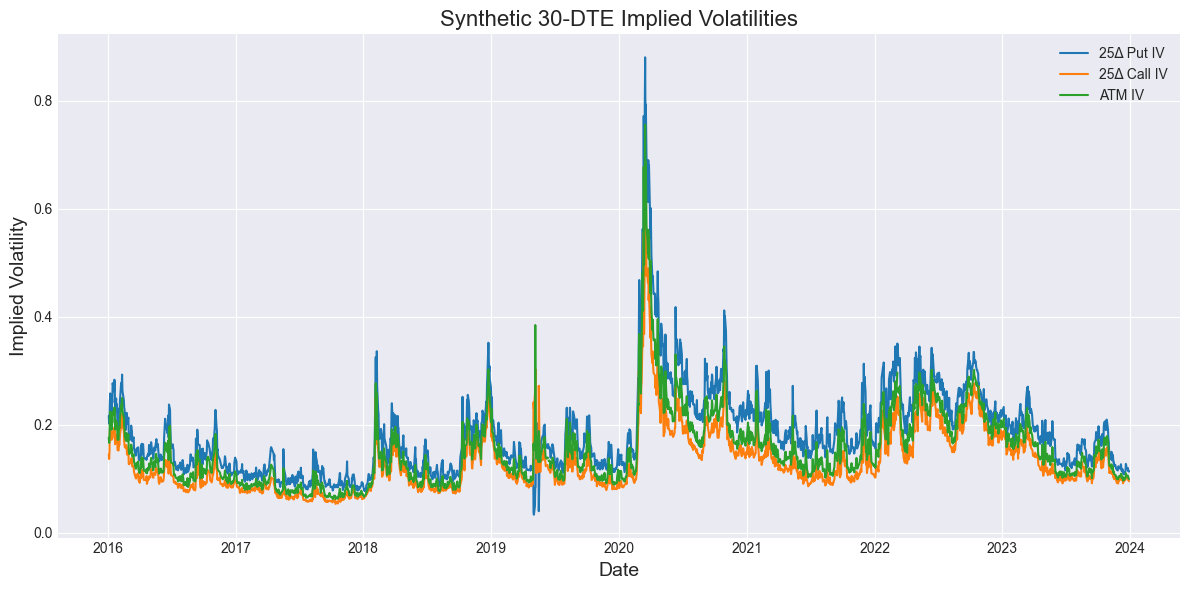

In [20]:
ph.plot_synthetic_ivs(synthetic_skew)

The relative ordering aligns with the typical smirk-shaped skew observed in equity index options, where the **IV of the OTM put is highest**, followed by the **ATM IV**, and finally the **OTM call IV as the lowest**. All three series generally move in the same direction, which is expected given their shared dependence on overall market volatility. 

We observe an anomaly around **2019-05-02**, where **OTM put IV drops abnormally to ~3%**, while it was around 14% the day before.  
After investigation, this is attributed to a **data issue**, and we choose to **drop all dates before `2019-05-17`**, where IV levels return to normal.

In [23]:
synthetic_skew.loc["2019-05":"2019-05-21"]

,iv_put_30,iv_call_30,iv_atm_30,skew_abs,skew_norm
date,,,,,
2019-05-01,0.136930,0.104320,0.112760,0.032610,0.289198
2019-05-02,0.038733,0.242215,0.165256,-0.203483,-1.231321
2019-05-03,0.033846,0.229720,0.152935,-0.195874,-1.280765
2019-05-06,0.049983,0.256049,0.176504,-0.206067,-1.167490
2019-05-07,0.083833,0.296453,0.385096,-0.212619,-0.552121
2019-05-08,0.084630,0.303170,0.223400,-0.218540,-0.978245
2019-05-09,0.202647,0.135291,0.165765,0.067356,0.406331
2019-05-10,0.172157,0.110937,0.137820,0.061220,0.444203
2019-05-13,0.202941,0.156270,0.180176,0.046670,0.259026


In [ ]:
synthetic_skew.loc["2019-05-02":"2019-05-08", :] = np.nan
synthetic_skew.loc["2019-05-17", :] = np.nan
synthetic_skew = synthetic_skew.interpolate(method="linear")
"""
safe_start_date = "2019-05-17"
synthetic_skew = synthetic_skew.loc[synthetic_skew.index > safe_start_date]
options = options.loc[options.index > safe_start_date]
"""

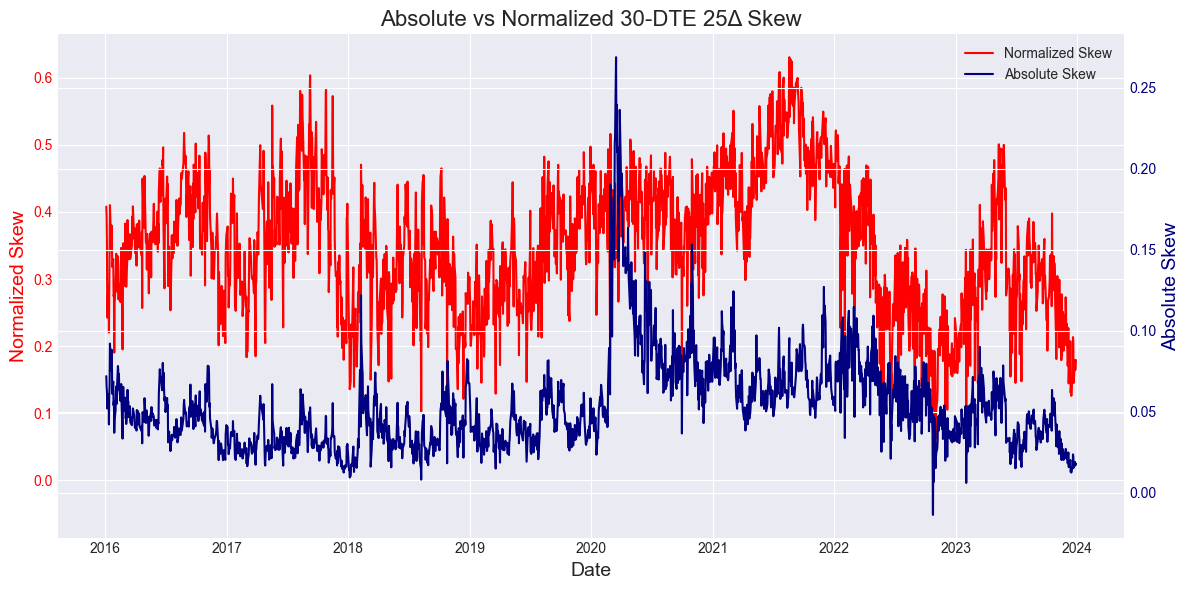

In [26]:
ph.plot_norm_abs_skew(synthetic_skew)

As shown, the absolute skew is more sensitive to changes in volatility regimes and exhibits higher noise over time — particularly during the first three months of heightened volatility. In contrast, the normalized skew remains more stable, making it better suited for generating consistent and reliable trading signals.

<a id='strat'></a>
# **5. Implement Trading Strategies**

We now leverage the skew metrics computed earlier to design and test trading strategies. The core idea we focus on is the empirically observed **mean-reverting behavior of the skew**.

In the first part, we introduce the option structure used to express trades based on the skew signal.

In the second part, we build the mean-reversion skew trading strategy itself, starting with simple signal definitions and progressively adding filters to improve trade quality.

## **5.1. Trade Expression Setup**

In options trading, skew is often **traded directly** using options structures that isolate the relative pricing of puts vs. calls. In our case we will trade the **Risk Reversal** structure whihc mimic the absolute skew as it consits in selling a 25Δ put and buy a 25Δ call when the skew is too steep and vice versa.

This notebook primarily focuses on **trading the skew directly through such option structures**, as they allow us to:
- Express a **pure view on volatility skew**,
- Minimize directional exposure (compared to trading the underlying),
- And benefit from changes in the **shape of the implied volatility surface**.

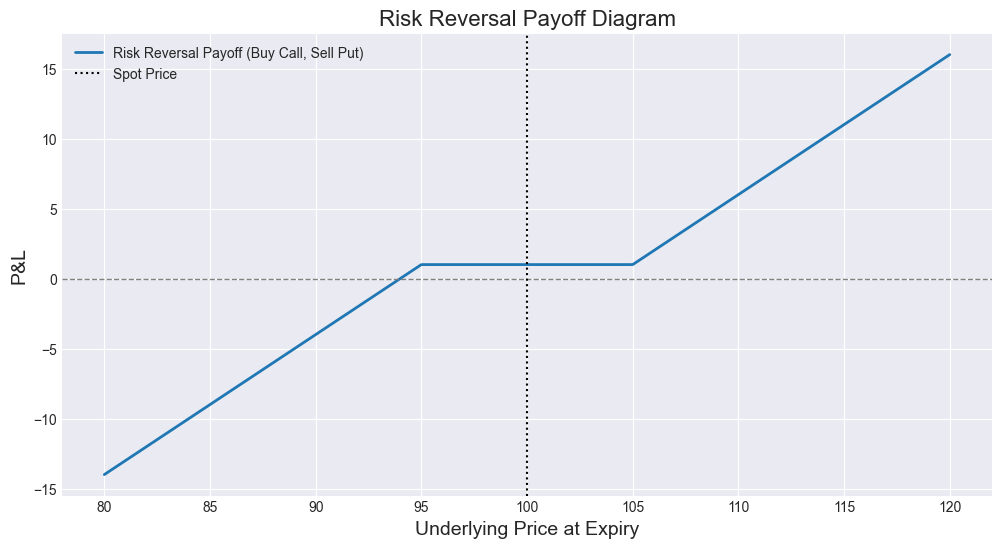

In [27]:
ph.plot_risk_reversal_payoff(spot_price=100, strike_put=95, strike_call=105, premium_put=3, premium_call=2)

This payoff represents the P&L we would earn if we held the options until expiry, which is rarely the case in skew trading. Intuitively, when the stock price declines, the skew tends to steepen, and since we are betting on a mean reversion of the skew (i.e., a flattening), this move results in a loss.

## **5.2. Strategy 1: Simple Mean Reversion on the Skew**

This strategy is based on the observation that skew tends to exhibit **mean-reverting behavior**. When the skew becomes abnormally high or low, it often reverts toward its long-term average.

We explore two methods:
1. A **fixed absolute skew threshold** approach, using static cutoff levels.
2. A **rolling z-score threshold** approach, which dynamically adjusts based on recent skew behavior.

Both methods provide a framework for identifying potential reversal points in the skew and constructing contrarian trades.

In [28]:
class Strategy(ABC):
    def __init__(self):
        self._z_score = None
        
    @abstractmethod
    def generate_signals(self, skew_series):
        """Returns a DataFrame of boolean columns [long, short, exit]"""
        pass

    @abstractmethod
    def get_params(self) -> dict:
        """Return current hyper-parameters as {name: value}."""
        pass

    @abstractmethod
    def set_params(self, **kwargs):
        """Update internal hyper-parameters."""
        pass

    def get_z_score(self):
        """Return the most recent zscore,
        or None if not a zscore strategy."""
        return self._z_score  

## **5.2.1 Signal 1: Fixed Absolute Skew Threshold**

This method is commonly used in exploratory research due to its simplicity and interpretability. It uses fixed absolute skew levels to identify extreme market conditions and trigger contrarian trades.

We define two static thresholds:

- **Upper threshold** $(\text{Skew}_{\text{Upper}})$: indicates excessive downside protection demand, a potential market top.
- **Lower threshold** $(\text{Skew}_{\text{Lower}})$: indicates complacency or upside overpricing, a potential market bottom.

These thresholds are chosen based on historical data and should be calibrated using a training sample to avoid forward-looking bias.

### **Trading Signals**

- **Long Signal**: Buy a reversed risk reversal when: $\text{Skew}_t < \text{Skew}_{\text{Lower}}$

- **Short Signal**: Buy a risk reversal when: $\text{Skew}_t > \text{Skew}_{\text{Upper}}$

- **Exit Signal**: Close the position when: $\text{Skew}_{\text{Lower}} \leq \text{Skew}_t \leq \text{Skew}_{\text{Upper}}$

This logic defines a simple contrarian trading strategy based on the assumption that extreme skew levels tend to revert toward a long-term equilibrium.

In [29]:
def threshold_strategy(skew, lower_threshold=0.01, upper_threshold=0.05):
    signals = pd.DataFrame(index=skew.index)
    signals["long"] = False
    signals["short"] = False
    signals["exit"] = False

    position = 0  # +1 = long, -1 = short, 0 = flat

    for i in range(len(skew)):
        if pd.isna(skew.iloc[i]):
            continue

        date = skew.index[i]
        value = skew.iloc[i]

        if position == 0:
            if value < lower_threshold:
                signals.at[date, "long"] = True
                position = 1
            elif value > upper_threshold:
                signals.at[date, "short"] = True
                position = -1
        else:
            if value >= lower_threshold and value <= upper_threshold:
                signals.at[date, "exit"] = True
                position = 0

    return signals

According to the plot it seems reasonbale to use a lwoer an dupper thrteshold of 0.02 and 0.06 respectively.

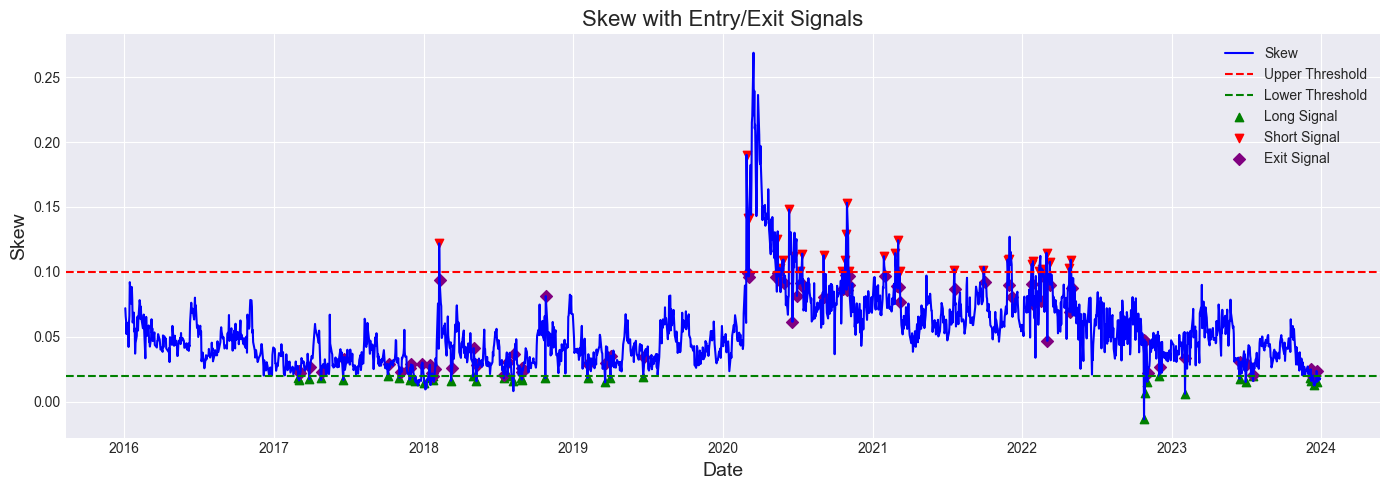

In [30]:
upper_threshold = 0.1
lower_threshold = 0.02

signals_abs_threshold = threshold_strategy(synthetic_skew["skew_abs"], lower_threshold, upper_threshold)

ph.plot_skew_signals(synthetic_skew["skew_abs"], signals_abs_threshold, lower_threshold, upper_threshold)

While this approach is straightforward to implement, it is **not adaptive** to changing volatility regimes and therefore requires caution. Moreover, by selecting thresholds on the same dataset used for backtesting, we introduce a **data-snooping bias**. To mitigate this, we will calibrate and evaluate our signals using a proper **walk-forward** framework later in Section 6.

## **5.2.2 Signal 2: Rolling Z-Score of the Skew**

COmpared to the the static fixed threshold appraoch which considers a fixed trheshold for the entire period, the rolling z score(a.k.a Bollnger Bands) adapts the buyign and selling threhsold based on markt conditons. When the voilaitltiy is higher the lower and upper threhsold will go away form the mean, so in low volaitltiy regimes the band will be anrrower but during high voality the band will spread out.

When the skew becomes extremely high or low relative to its historical average, it may signal fear or complacency in the market:

- A **high skew Z-score** implies elevated demand for downside protection → potential **market top or correction** ahead.
- A **low skew Z-score** implies low demand for puts → potential **bounce or rally** ahead.


We define the Z-score of the skew as:

$$
Z_t = \frac{\text{Skew}_t - \mu_{\text{Skew}}}{\sigma_{\text{Skew}}}
$$

Where:
- $\text{Skew}_t$ is the skew on day *t*
- $\mu_{\text{Skew}}$ is the rolling mean of the skew
- $\sigma_{\text{Skew}}$ is the rolling standard deviation

In [31]:
def compute_zscore(series, window=60):
    return (
        (series - series.rolling(window).mean()) /
         series.rolling(window).std()
    )

window_score = 60
synthetic_skew.loc[:, "skew_zscore"] = compute_zscore(
    synthetic_skew["skew_norm"], window=window_score
)

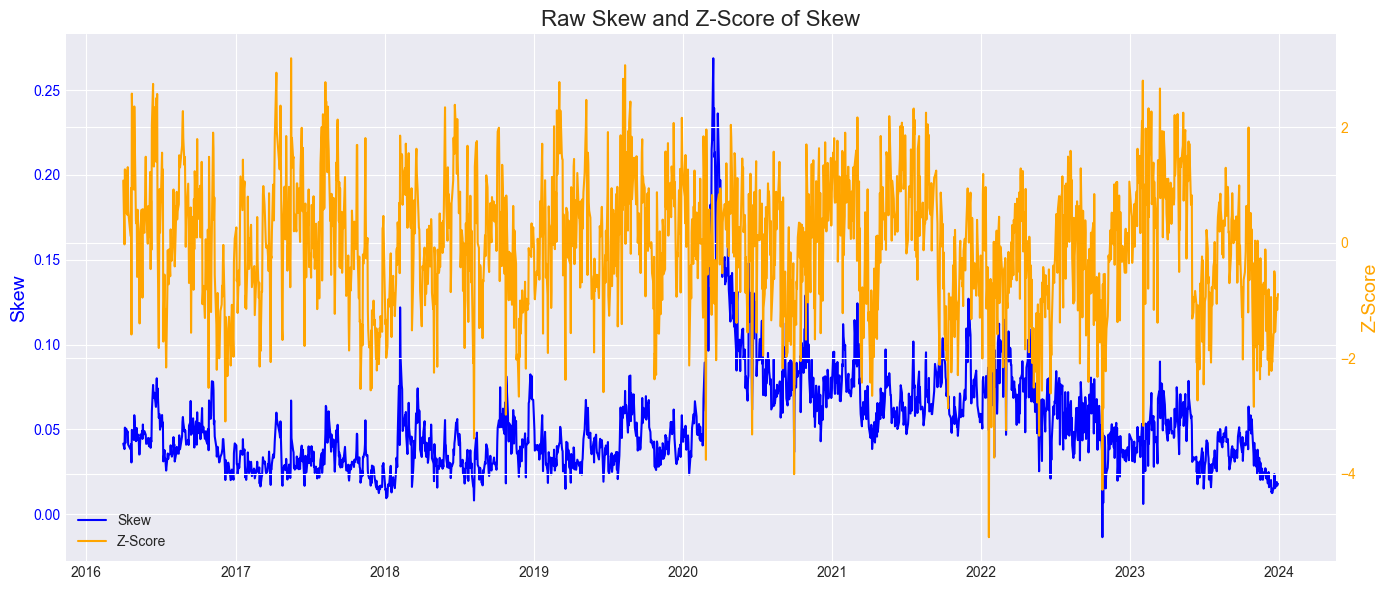

In [32]:
ph.plot_skew_vs_zscore(synthetic_skew)

When the skew makes a sudden large move, the z-score amplifies that move relative to its recent volatility and average value, making it easier to spot extreme events.

#### **Trading Signals**

- **Short Signal**: Buy a risk reversal when: $Z_t > Z_{entry}$

- **Long Signal**: Buy a reversed risk reversal when: $Z_t < -Z_{entry}$

- **Exit Signal**: Close any position when:  $-Z_{exit} ≤ Z_t ≤ Z_{exit}$

In most implementations:  
- $Z_{entry} = 1.5$
- $Z_{exit}  = 0.5$

This approach assumes that extreme deviations in skew (captured by z-scores) reflect **excess fear or complacency**, providing contrarian entry and exit points.

In [33]:
class ZScoreStrategy(Strategy):
    def __init__(self, window=60, entry=2.0, exit=0.5):
        self.window = window
        self.entry = entry
        self.exit  = exit

    def get_params(self):
        return {
            "strategy__window": self.window,
            "strategy__entry":  self.entry,
            "strategy__exit":   self.exit,
        }

    def set_params(self, window=None, entry=None, exit=None, **kwargs):
        if window is not None: self.window = window
        if entry is not None:  self.entry  = entry
        if exit is not None:   self.exit   = exit
        if kwargs:
            unexpected = ", ".join(kwargs.keys())
            raise TypeError(f"Unexpected parameters passed to ZScoreStrategy: {unexpected}")

    def generate_signals(self, skew_series):
        z_score = compute_zscore(skew_series, window=self.window)
        signals = pd.DataFrame(index=z_score.index)
        signals["long"] = False
        signals["short"] = False
        signals["exit"] = False

        self._z_score = z_score

        position = 0  # +1 = long, -1 = short, 0 = flat
        for i in range(len(z_score)):
            if pd.isna(z_score.iloc[i]):  # Skip NaN values for rolling
                continue

            if position == 0: 
                # Enter long position
                if z_score.iloc[i] < -self.entry:
                    signals.at[z_score.index[i], "long"] = True
                    position = 1
                # Enter short position
                elif z_score.iloc[i] > self.entry:
                    signals.at[z_score.index[i], "short"] = True
                    position = -1 

            elif position == 1: 
                # Exit long position
                if z_score.iloc[i] >= -self.exit:
                    signals.at[z_score.index[i], "exit"] = True
                    position = 0

            elif position == -1:
                # Exit short position
                if z_score.iloc[i] <= self.exit:
                    signals.at[z_score.index[i], "exit"] = True
                    position = 0

        return signals  

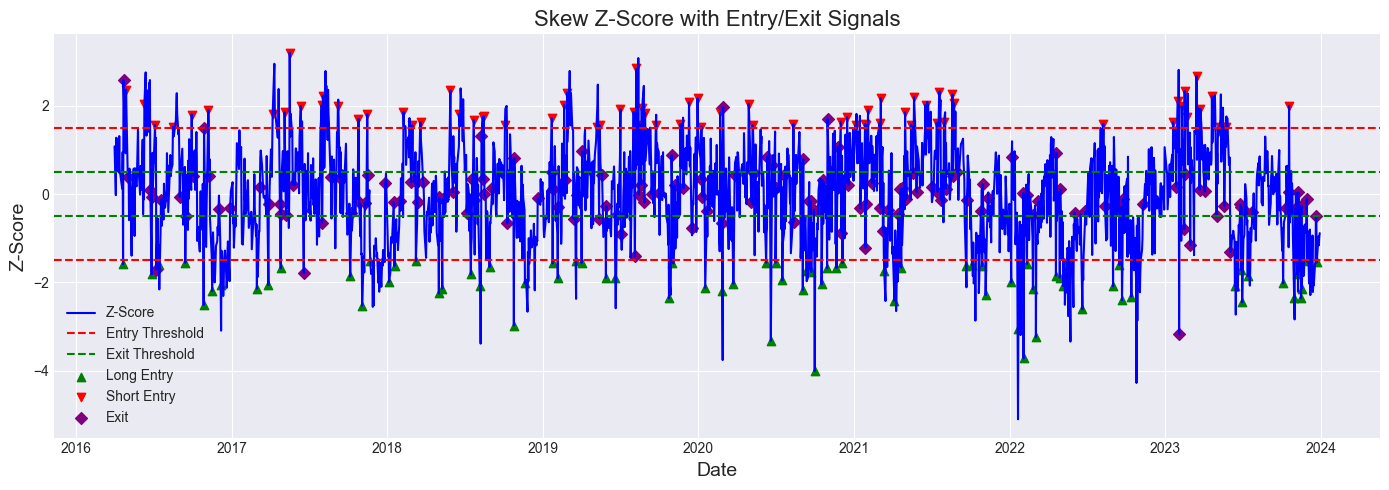

In [34]:
entry_zscore = 1.5
exit_zscore = 0.5

z_score_strategy = ZScoreStrategy(window=window_score,entry=entry_zscore, exit=exit_zscore)
signals_zscore = z_score_strategy.generate_signals(synthetic_skew["skew_norm"])

ph.plot_zscore_signals(
    synthetic_skew["skew_zscore"], 
    signals_zscore, 
    entry_zscore, 
    exit_zscore
)

To make it more obvious about how the staretgye adapts to the market condition, we plot the skew on top of the rollign mean and upper and lower bands computed based on mutilple of the rolling standard deviations.



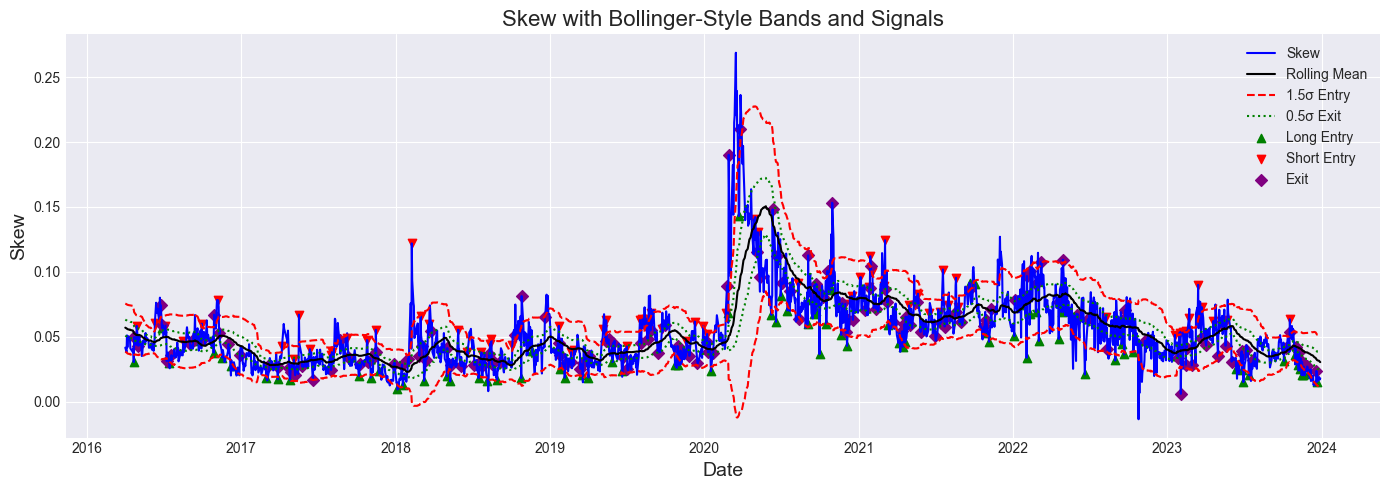

In [35]:
ph.plot_boll_bands(synthetic_skew, signals_zscore)

## **5.3. Strategy 2: Mean Reversion with IV-Percentile, Skew Percentile and VIX Filters**

Using the **rolling Z-score of the skew** in isolation can lead to a high number of **false positives**. While skew often exhibits mean-reverting tendencies, this behavior is not always reliable, especially during trending or high-volatility regimes.

To reduce noise and increase **signal quality**, we introduce several **filters** that must be satisfied before a trade is taken. These filters aim to validate the skew signal in the broader market context.


In [36]:
class Filter(ABC):
    @abstractmethod
    def apply(self, signals, ctx):
        pass # returns the filtered signals

    @abstractmethod
    def get_params(self):
        """Return current hyper-parameters as {name: value}."""
        pass

    @abstractmethod
    def set_params(self, **kwargs):
        """Update internal hyper-parameters."""
        pass

### **5.3.3 Volatility Regime Filter: IV Percentile (IVP)**

The **Implied Volatility Percentile (IVP)** measures where current implied volatility stands relative to its historical distribution over a rolling window. It provides a normalized view of volatility regimes.

#### **Formula**:
Let $\text{IV}_t$ be the current implied volatility (e.g., 30-day ATM IV), and $\text{IV}_{t-w:t}$ be the window of past implied volatilities over the last $w$ days.

$$
\text{IVP}_t = \frac{\# \{ \text{IV}_i \in \text{IV}_{t-w:t} \, | \, \text{IV}_i \leq \text{IV}_t \}}{w}
$$

That is, **IVP is the percentile rank of today's implied volatility compared to the past \( w \) days**.

In [37]:
def compute_iv_percentile(iv_series, window=252):
    return iv_series.rolling(window).apply(
        lambda x: (x[-1] > x).sum() / window,
        raw=True
    )

ivp_window = 252
synthetic_skew.loc[:, "ivp"] = compute_iv_percentile(
    synthetic_skew["iv_atm_30"], window=ivp_window
)

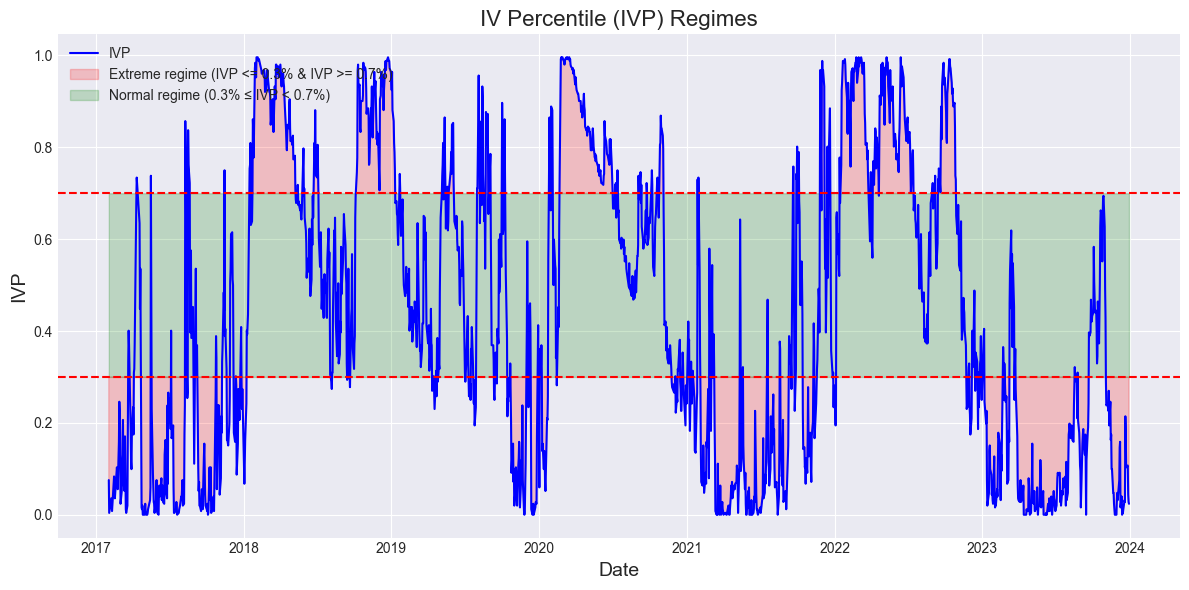

In [38]:
ivp_lower_threshold = 30
ivp_upper_threshold = 70

ph.plot_ivp(synthetic_skew["ivp"], ivp_lower_threshold, ivp_upper_threshold)

#### **Trading Filter:**
Mean-reversion strategies on the skew tend to perform best under *normal market conditions*. Extreme volatility, either too low (complacency) or too high (panic), can distort typical skew behavior and reduce edge.

**Trading Rule**: Only take trades when **30% ≤ IVP ≤ 70**

**Filter Rule**:
- **IVP < 30%**: Volatility is abnormally low, markets may be quiet or complacent, reducing skew movement.
- **IVP > 70%**: Volatility is elevated, possibly due to stress or uncertainty.

In [39]:
class IVPFilter(Filter):
    def __init__(self, window=252, lower=30, upper=70):
        self.window = window
        self.lower = lower / 100
        self.upper = upper / 100

    def get_params(self):
        return {
            "ivpfilter__window": self.window,
            "ivpfilter__lower":  int(self.lower * 100),
            "ivpfilter__upper":  int(self.upper * 100),
        }

    def set_params(self, window=None, lower=None, upper=None, **kwargs):
        if window is not None:
            self.window = window
        if lower is not None:
            self.lower = lower / 100
        if upper is not None:
            self.upper = upper / 100
        if kwargs:
            unexpected = ", ".join(kwargs.keys())
            raise TypeError(f"Unexpected parameters passed to IVPFilter: {unexpected}")

    def apply(self, signals, ctx):
        iv_atm = ctx["iv_atm"]
        ivp = compute_iv_percentile(
            iv_atm, 
            window=self.window
        )

        out = signals.copy()
        ivp_mask = (
            (ivp >= self.lower) &
            (ivp <= self.upper) 
        )
        out.loc[~ivp_mask, ['long','short','exit']] = False

        return out

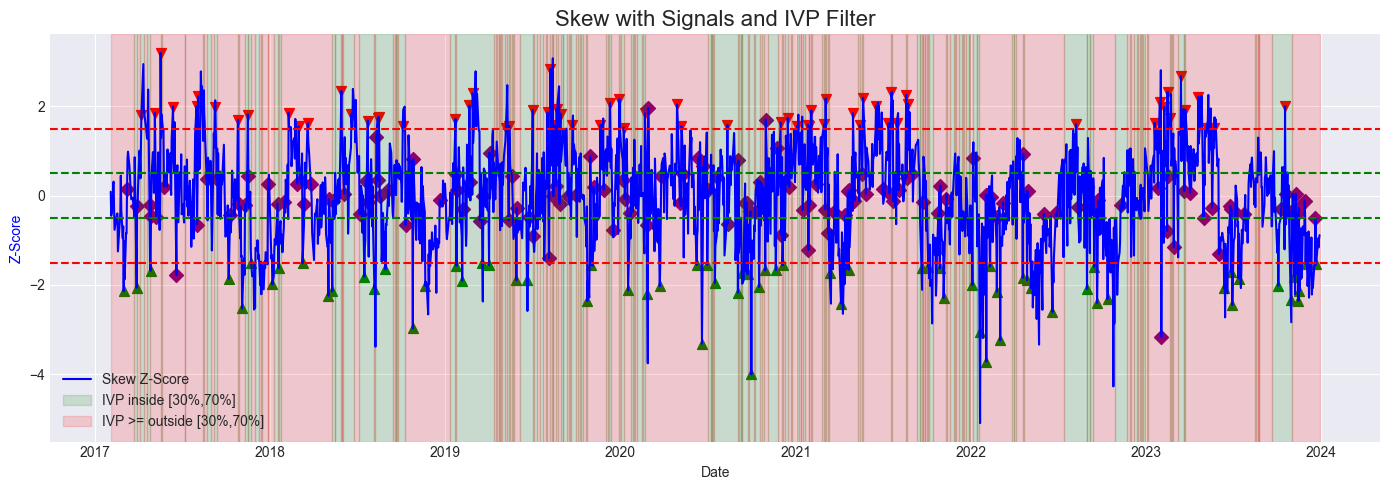

In [40]:
ph.plot_zscore_signals_with_ivp(
    synthetic_skew["skew_zscore"], signals_zscore, synthetic_skew["ivp"], 
    entry_zscore, exit_zscore, 
    ivp_lower_threshold, ivp_upper_threshold
)

### **5.3.4 Skew Regime Filter: Skew Percentile**

The **Skew Percentile** measures where the current skew stands relative to its historical distribution over a rolling window. Unlike a short-term z-score, it provides a broader context about the skew regime over a longer period.

#### **Formula**:

Let $ \text{Skew}_t $ be the current skew value (e.g., normalized 25-delta risk reversal), and $ \text{Skew}_{t-w:t} $ the rolling window of past skew values.

$$
\text{SkewPercentile}_t = \frac{\# \left\{ \text{Skew}_i \in \text{Skew}_{t-w:t} \,\middle|\, \text{Skew}_i \leq \text{Skew}_t \right\}}{w}
$$

This gives the percentile rank of today’s skew compared to the past $w$ days.

In [41]:
def compute_skew_percentile(skew, window=252):
    return skew.rolling(window).apply(
        lambda x: (x[-1] > x).sum() / window,
        raw=True
    )

skew_perc_window = 252
synthetic_skew.loc[:, "skew_perc"] = compute_skew_percentile(
    synthetic_skew["skew_norm"], window=skew_perc_window
)

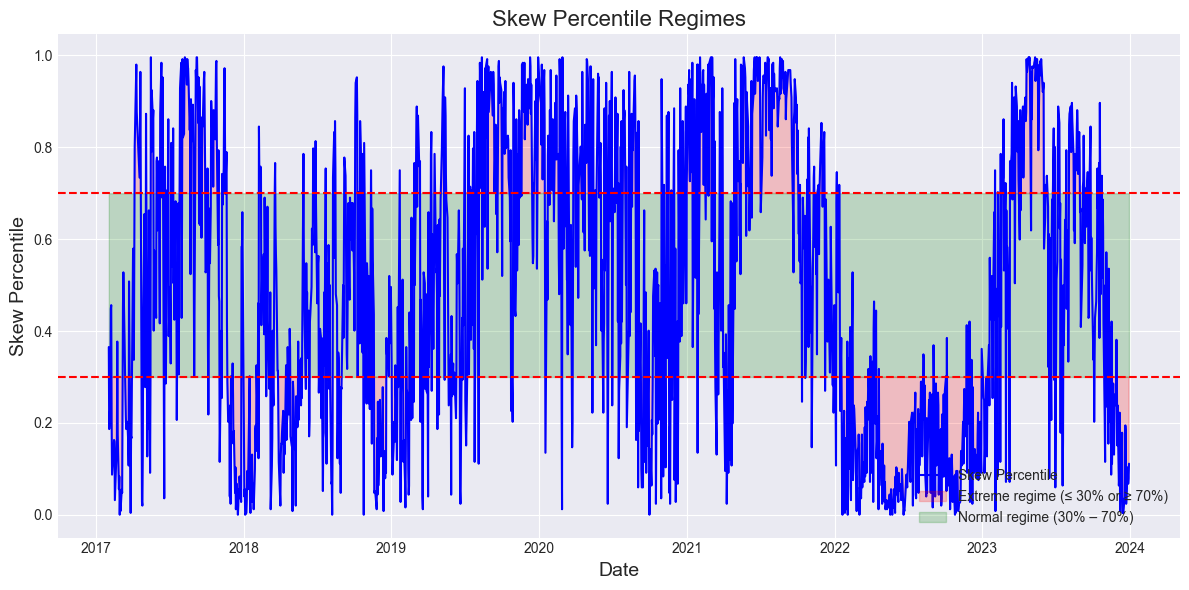

In [42]:
skew_perc_lower = 30
skew_perc_upper = 70

ph.plot_skew_percentile(synthetic_skew["skew_perc"], skew_perc_lower, skew_perc_upper)

### **Trading Filter**

This filter ensures that skew trades are only taken when the skew is at statistically **extreme levels** compared to its historical range. It complements the z-score signal by capturing *longer-term context* and avoiding trades during neutral or noisy skew environments.

#### **Trading Rule**:  
Only take skew trades when **Skew Percentile ≤ 20%** (long) or **Skew Percentile ≥ 80%** (short).


#### **Filter Rule**:
- $20\% < \text{Skew Percentile} < 80\%$: Skew is in a neutral regime, signals are **filtered out** to avoid low-conviction trades.

In [43]:
class SkewPercentileFilter(Filter):
    def __init__(self, window=252, lower=30, upper=70):
        self.window = window
        self.lower = lower / 100
        self.upper = upper / 100

    def get_params(self):
        return {
            "skewpercentilefilter__window": self.window,
            "skewpercentilefilter__lower":  int(self.lower * 100),
            "skewpercentilefilter__upper":  int(self.upper * 100),
        }

    def set_params(self, window=None, lower=None, upper=None, **kwargs):
        if window is not None:
            self.window = window
        if lower is not None:
            self.lower = lower / 100
        if upper is not None:
            self.upper = upper / 100
        if kwargs:
            unexpected = ", ".join(kwargs.keys())
            raise TypeError(f"Unexpected parameters passed to SkewPercentileFilter: {unexpected}")
        
    def apply(self, signals, ctx):
        skew = ctx["skew_norm"]
        skew_perc = compute_skew_percentile(
            skew, 
            window=self.window
        )
        
        out = signals.copy()
        long_mask  = (skew_perc <= self.lower)
        short_mask = (skew_perc >= self.upper)

        out['long']  = out['long']  & long_mask
        out['short'] = out['short'] & short_mask
        out['exit']  = out['exit']  # exit logic is left unchanged

        return out

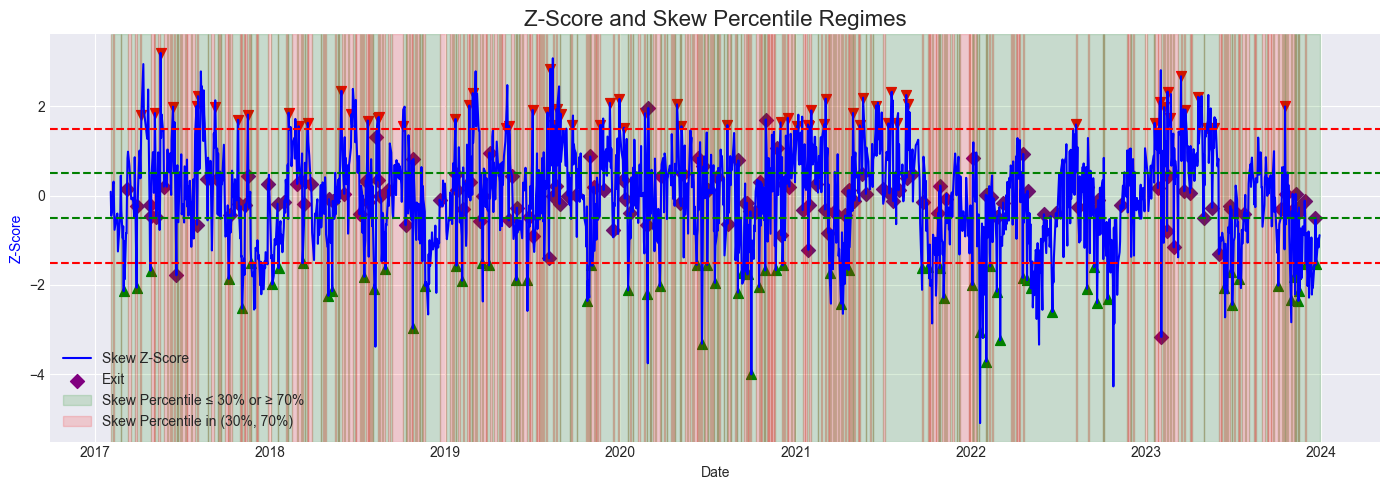

In [44]:
ph.plot_zscore_signals_with_skew_percentile(
    synthetic_skew["skew_zscore"], signals_zscore, synthetic_skew["skew_perc"],
    entry_zscore, exit_zscore, 
    skew_perc_lower, skew_perc_upper
)

### **5.3.1 Sentiment Filter: VIX**

The **VIX index** reflects the market's expectation of near-term volatility and is often viewed as a gauge of investor sentiment and systemic stress.

During periods of extreme volatility, skew may remain elevated and risk reversal trades are less reliable.

In [45]:
start_date = synthetic_skew.index[0].date()
end_date = synthetic_skew.index[-1].date()

vix = yf.download("^VIX", start=start_date, end=end_date)
vix = vix["Close"].squeeze()
vix.name = "Vix"
vix.index.name = "date"

common_dates = synthetic_skew.index.intersection(vix.index)

vix = vix.loc[common_dates]
synthetic_skew = synthetic_skew.loc[common_dates]
options = options.loc[common_dates]
signals_zscore = signals_zscore.loc[common_dates]

synthetic_skew.index.name = "date"
vix.index.name = "date" 
options.index.name = "date"
signals_zscore.index.name = "date"

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_20198/1552151661.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


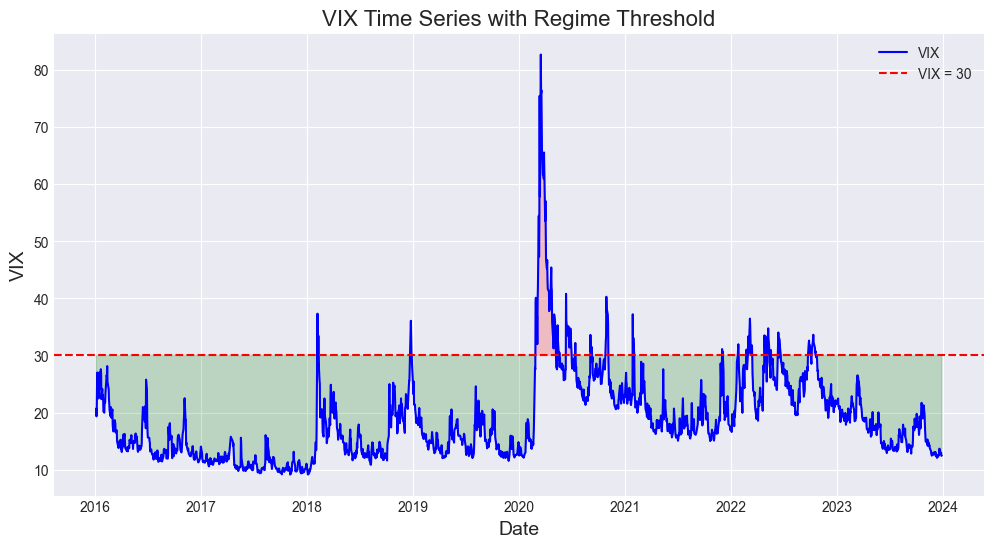

In [46]:
vix_threshold = 30
ph.plot_vix(vix, vix_threshold=vix_threshold)

### **Trading Filter**
This filter complements the IVP filter by capturing broader market conditions. Even when IVP appears moderate (e.g., around 50%), a high VIX may indicate hidden instability or risk-off sentiment that could impair the reliability of skew mean-reversion.

#### **Trading Rule**:  
  Only allow skew trades when **VIX < 25–30**


#### **Filter Logic**:
  - **VIX ≥ 25-30**: Market may be under stress, **filter out** skew trades.
  - **VIX < 25-30**: Conditions are calmer, allow trading.

In [47]:
class VIXFilter(Filter):
    def __init__(self, panic_threshold=25, mom_threshold=0.10):
        self.panic_threshold = panic_threshold
        self.mom_threshold = mom_threshold

    def get_params(self):
        return {
            "vixfilter__panic_threshold": self.panic_threshold,
            "vixfilter__mom_threshold":   self.mom_threshold,
        }

    def set_params(self, panic_threshold=None, mom_threshold=None, **kwargs):
        if panic_threshold is not None:
            self.panic_threshold = panic_threshold
        if mom_threshold is not None:
            self.mom_threshold = mom_threshold
        if kwargs:
            unexpected = ", ".join(kwargs.keys())
            raise TypeError(f"Unexpected parameters passed to VIXFilter: {unexpected}")

    def apply(self, signals, ctx):
        vix = ctx["vix"]
        vix_mask = (vix < self.panic_threshold)
        out = signals.copy()
        out.loc[~vix_mask, ['long','short','exit']] = False
        return out

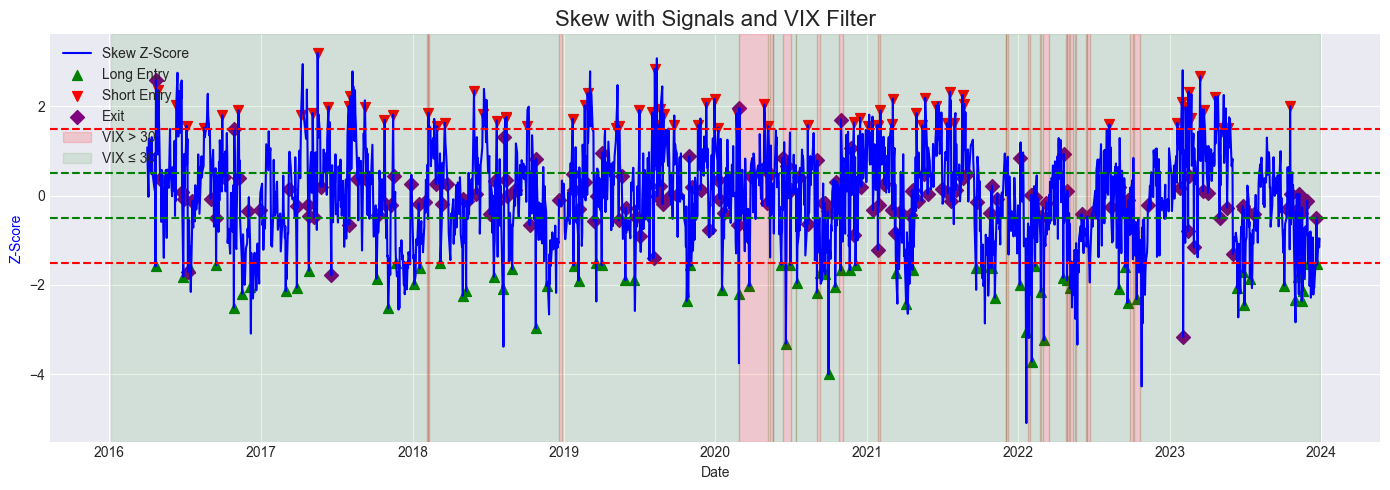

In [48]:
ph.plot_zscore_signals_with_vix(
    synthetic_skew["skew_zscore"], signals_zscore, vix, entry_zscore, exit_zscore, 
    vix_filter=vix_threshold, title="Skew with Signals and VIX Filter"
)

We observe that the **VIX filter effectively prevented trading during the COVID crash**, successfully filtering out signals during periods of extreme market volatility. However, it **failed to block the trade initiated just before the lockdown announcement on March 15**, highlighting a limitation in its responsiveness to rapidly evolving market conditions.

## **6. Backtesting Framework with Walk-Forward Cross-Validation & Risk Controls**

We evaluate our 30 DTE / 25 Δ skew mean-reversion strategy out-of-sample via a rolling walk-forward framework, embedding realistic execution and risk controls:

- **Transaction Costs**
  - **Bid/Ask & SLippage:** Fill sells at the bid, buys at the ask, plus a small slippage buffer. 
  - **Commissions:** Charge a fixed fee per option leg to capture transaction costs.


- **Risk Management**  
  - **Position Sizing:** Scale trade size by skew z-score conviction *and* a dollar-risk budget.  
  - **Delta Hedging:** Neutralize directional exposure with futures or spot hedges.  
  - **Stop-Loss & Take-Profit:** Exit when P&L hits predefined percentages of notional.  
  - **Holding Period Cap:** Force closure after a maximum number of days to limit tail risk.


- **P&L & Greeks Monitoring**  
  - **Realized vs. Unrealized P&L:** Record both closed‐trade P&L and daily mark-to-market P&L  
  - **Greek Exposures:** Track total Δ, Γ, Vega, Θ per day for ongoing positions  


- **Model Validation**  
  - **Walk-Forward Testing:** Roll in-sample/out-of-sample windows forward to mimic live trading and update capital sequentially  
  - **Cross-Validation:** Grid‐search hyperparameters on rolling train/validation splits using a composite score (Sharpe, max-drawdown, profit factor) 
  - **Stress Testing:** Run Greek-based “what-if” scenarios (spot shocks, vol spikes, multi-day decay) on the equity curve.

By integrating these practical constraints at every step, our backtest captures both the strategy’s statistical edge and the real-world P&L impacts.  

In [79]:
class Backtester:
    def __init__(
        self,
        options, 
        synthetic_skew, 
        vix,
        hedge_series,
        strategy,
        filters,
        position_sizing,
        find_viable_dtes,
        params_grid=None,
        train_window=252,
        val_window=63,
        test_window=63,
        step=None,
        target_dte=30, 
        target_delta_otm=0.25, delta_tolerance=0.05, 
        holding_period=5,
        stop_loss_pct=0.2, take_profit_pct=0.6,
        theta_decay_weekend=200,
        lot_size=100,
        hedge_size=50,
        slip_ask=0.01, slip_bid=0.01,
        commission_per_leg=1.00, 
        initial_capital=100000
    ):
        # data
        self.options = options
        self.synthetic_skew = synthetic_skew
        self.vix = vix
        self.hedge_series = hedge_series

        # strategy object & filter list objects
        self.strategy = strategy
        self.filters = filters

        # external functions
        self.position_sizing = position_sizing
        self.find_viable_dtes = find_viable_dtes

        # parameters for tuning
        self.params_grid = params_grid

        # parameters for walk froward
        self.train_window = train_window
        self.val_window = val_window
        self.test_window = test_window
        self.step = step
        if self.step is None:
            self.step = self.test_window

        # risk reversal params
        self.target_dte = target_dte
        self.target_delta_otm = target_delta_otm
        self.delta_tolerance = delta_tolerance

        # risk management params
        self.holding_period = holding_period
        self.stop_loss_pct = stop_loss_pct
        self.take_profit_pct = take_profit_pct
        self.theta_decay_weekend = theta_decay_weekend

        # backtest params
        self.lot_size = lot_size
        self.hedge_size = hedge_size
        self.slip_ask = slip_ask
        self.slip_bid = slip_bid
        self.commission_per_leg = commission_per_leg
        self.initial_capital = initial_capital
        self.current_capital = initial_capital

        # --- auto-compute the warm lookback 
        #     for computing signals and filters ---
        base_windows = [strategy.window]
        base_windows += [
            f.window for f in filters if hasattr(f, 'window')
        ]
        if self.params_grid is not None:
            for key, values in self.params_grid.items():
                if key.endswith("__window"):
                    for w in values:
                        base_windows.append(int(w))

        # the lookback window is the maximum window size
        self.lookback = max(base_windows)


    ###################
    # Static methods #
    ###################

    # --- Public Methods ---
    @staticmethod
    def compute_sharpe_ratio(returns, rf=0.0):
        return (
            (returns.mean() - rf)/returns.std()*np.sqrt(252) 
            if not returns.empty 
            else -np.inf
        )

    @staticmethod
    def stress_test(mtm_daily, scenarios):
        pnl_df = pd.DataFrame(index=mtm_daily.index)
        for name, shock in scenarios.items():
            dS = shock['dS_pct'] * mtm_daily['S']
            pnl_df[f'PnL_{name}'] = (
                mtm_daily['net_delta_prev'] * dS
                + 0.5 * mtm_daily['gamma_prev'] * dS**2
                +       mtm_daily['vega_prev']  * shock['dSigma']
                +       mtm_daily['theta_prev'] * shock['dt']
            )
        return pnl_df
    
    #  --- Private Methods ---
    @staticmethod
    def _pick_quote(df_leg, tgt, delta_tolerance=0.05):
        df2 = df_leg.copy()
        df2['d_err'] = (df2['delta'] - tgt).abs()
        df2 = df2[df2['d_err'] <= delta_tolerance]
        if df2.empty:
            return None
        return df2.iloc[df2['d_err'].values.argmin()]


    ###################
    # Private methods #
    ###################
    
    def _apply_filters(self, start_date, end_date, raw_signals):
        ctx = self._make_context(start_date, end_date)
        signals = raw_signals.copy()
        for filt in self.filters:
            signals = filt.apply(signals, ctx)
        return signals
    
    def _make_context(self, start_date, end_date):
        """Stores relevent info to pass to strategy and filters"""
        idx = self.synthetic_skew.index
        pos_start = idx.get_loc(start_date)
        pos_end = idx.get_loc(end_date)
        start = idx[
            max(0, pos_end - (self.lookback + (pos_end - pos_start)))
        ]
        
        skew = self.synthetic_skew.loc[start:end_date, 'skew_norm']
        iv_atm = self.synthetic_skew.loc[start:end_date, 'iv_atm_30']
        vix = self.vix.loc[start:end_date]
        return {
            'skew_norm': skew, 'iv_atm': iv_atm, 'vix': vix
        }

    def _generate_signals(self, start_date, end_date):
        idx = self.synthetic_skew.index
        pos_start = idx.get_loc(start_date)
        pos_end = idx.get_loc(end_date)
        start = idx[max(0, pos_end - (self.lookback + (pos_end - pos_start)))]

        skew = self.synthetic_skew.loc[start:end_date, 'skew_norm']
        signals = self.strategy.generate_signals(skew)
        return signals

    def _compute_score(self, trades, eq, w_sr, w_max_dd, w_pf, pf_eps=1e-6):
        if trades.empty or eq.empty:
            return -np.inf
        
        # Sharpe ratio 
        daily_ret = eq.equity.pct_change().dropna()
        sr    = Backtester.compute_sharpe_ratio(daily_ret)

        # Max drawdown
        peak   = eq.equity.cummax()
        dd     = (eq.equity - peak) / peak
        max_dd = dd.min()

        # Profit factor with floor & dynamic cap
        wins    = trades.loc[trades.pnl > 0, "pnl"].sum()
        losses  = -trades.loc[trades.pnl <= 0, "pnl"].sum()
        losses  = max(losses, pf_eps)         # avoid division by zero
        raw_pf  = wins / losses

        n_trades = len(trades)
        if losses <= pf_eps:
            # zero losses, apply piecewise cap
            if n_trades <= 3:
                pf_cap = 1.5
            elif n_trades <= 6:
                pf_cap = 2.0
            elif n_trades <= 15:
                pf_cap = 3.0
            else:
                pf_cap = 5.0
            pf = min(raw_pf, pf_cap)
        else:
            # at least one loss, trust raw PF
            pf = raw_pf

        # 4) Composite score
        return w_sr*sr - w_max_dd*abs(max_dd) + w_pf*pf
    
    def _score_params(
            self, train_idx, val_idx,
            top_k=5, w_sr=0.5, w_max_dd=0.3, w_pf=0.2, 
    ):
        """
        For each hyper–parameter combo:
          1. Backtest on the training slice and score via our composite 
          metric (Sharpe, maximum drawdown, profit factor).
          2. Keep the top_k.
          3. Re–test those on the validation slice, again with
             the same composite metric, and pick the best overall.
        """
        opts_train = self.options.loc[train_idx]
        opts_val = self.options.loc[val_idx]
        first_train, last_train = train_idx[0], train_idx[-1]
        first_val, last_val = val_idx[0], val_idx[-1]
        grid = list(ParameterGrid(self.params_grid))

        def score_on_slice(params, opts, idx, first, last):
            """Apply params, generate signals, backtest, compute score."""
            self._set_all_params(params)
            sig = self._generate_signals(first, last)
            sig = self._apply_filters(first, last, sig)
            trades, eq = self._backtest_risk_reversal(
                opts, sig.loc[idx], capital=self.initial_capital
            )
            return (
                self._compute_score(trades, eq, w_sr, w_max_dd, w_pf), params
            )

        # 1) Score training slice in parallel
        train_results = Parallel(n_jobs=-1)(
            delayed(score_on_slice)(
                p, opts_train, train_idx, first_train, last_train
            )
            for p in grid
        )
        
        if not train_results:
            return None

        # pick top_k by training score
        best_candidates = [
            params 
            for _, params in sorted(
                train_results,
                key=lambda x: x[0], # sort by the score only
                reverse=True
            )[:top_k]
        ]

        # 2) Score those on validation slice (serially)
        best_score, best_params = -np.inf, None
        for params in best_candidates:
            score_val, _ = score_on_slice(
                params, opts_val, val_idx, first_val, last_val
            )
            if score_val > best_score:
                best_score, best_params = score_val, params

        return best_params

    def _set_all_params(self, params):
        """Utility to split and set strategy & filter params"""
        s = {
            k.split("__",1)[1]:v 
            for k,v in params.items() 
            if k.startswith("strategy__")
        }
        self.strategy.set_params(**s)

        for filt in self.filters:
            name = filt.__class__.__name__.lower()+"__"
            f = {
                k.split("__",1)[1]:v 
                for k,v in params.items() 
                if k.startswith(name)
            }
            filt.set_params(**f)

    def _compute_greeks_per_contract(self, put_q, call_q, put_side, call_side):
        delta = (
            put_side*put_q['delta'] + call_side*call_q['delta']
        ) * self.lot_size

        gamma = (
            put_side*put_q['gamma'] + call_side*call_q['gamma']
        ) * self.lot_size

        vega = (
            put_side*put_q['vega'] + call_side*call_q['vega']
        ) * self.lot_size

        theta = (
            put_side*put_q['theta'] + call_side*call_q['theta']
        ) * self.lot_size

        return delta, gamma, vega, theta

    def _backtest_risk_reversal(self, options, signals, capital):
        trades = []
        mtm_records = []  # daily MTM P&L and Greeks
        roundtrip_comm = 2 * self.commission_per_leg
        last_exit = None

        for entry_date, sig in signals.iterrows():
            if not (sig.get('long', False) or sig.get('short', False)):
                continue
            if entry_date not in options.index:
                continue
            if entry_date == last_exit:
                continue

            # --- choose expiry closest to target dte---
            chain = options.loc[entry_date]
            d1, d2 = self.find_viable_dtes(
                chain, self.target_dte,
                target_delta_otm=self.target_delta_otm,
                delta_tolerance=self.delta_tolerance
            )
            dtes = [d for d in (d1, d2) if d is not None]
            if not dtes:
                continue
            chosen_dte = min(dtes, key=lambda d: abs(d - self.target_dte))
            chain = chain[chain['dte'] == chosen_dte]
            expiry = chain['expiry'].iloc[0]

            # --- pick entry quotes and strikes for put and call ---
            put_q = self._pick_quote(chain[chain.option_type=='P'], 
                                    -self.target_delta_otm, 
                                    self.delta_tolerance
            )
            call_q = self._pick_quote(chain[chain.option_type=='C'],  
                                     self.target_delta_otm, 
                                     self.delta_tolerance
            )
            if put_q is None or call_q is None:
                continue

            # --- decide put vs call side ---
            put_side  = -1 if sig['short'] else 1
            call_side =  1 if sig['short'] else -1

            # --- entry options prices (per contract) ---
            put_entry = (
                (put_q['bid'] - self.slip_bid) if sig['short']
                else (put_q['ask'] + self.slip_ask)
            )
            call_entry = (
                (call_q['ask'] + self.slip_ask) if sig['short']
                else (call_q['bid'] - self.slip_bid)
            )

            # --- position sizing ---
            # compute greeks per contract
            delta_pc, gamma_pc, vega_pc, theta_pc = (
                self._compute_greeks_per_contract(
                    put_q, call_q, put_side, call_side)
            )

            # define stress-test shock parameters
            S_entry = options.loc[entry_date, 'underlying_last'].iloc[0]
            iv_entry = self.synthetic_skew.loc[entry_date, 'iv_atm_30']
            ΔS = 0.05 * S_entry
            Δsigma = 0.02
            dt = self.holding_period

            # calculate worst-case $ risk per contract
            risk_per_contract = (
                0.5*abs(gamma_pc)*(ΔS**2) + # worst-case gamma PnL
                abs(vega_pc)*Δsigma +      # worst-case vega PnL
                max(-theta_pc*dt, 0.0)  # only charge time-decay if neg
            )

            # get position size 
            z = self.strategy.get_z_score().loc[entry_date]
            contracts = self.position_sizing(
                z=z,
                capital=capital,
                risk_per_contract=risk_per_contract,
                entry_threshold=self.strategy.entry,
            )
            if contracts <= 0:
                continue

            # --- define stop loss and take profit levels ---
            net_entry = (
                (put_side*put_entry + call_side*call_entry) * 
                self.lot_size * contracts
            )
            sl_level = -self.stop_loss_pct * abs(net_entry)
            tp_level =  self.take_profit_pct * abs(net_entry)

            # --- compute Greeks across all contracts---
            delta = delta_pc * contracts
            gamma = gamma_pc * contracts
            vega  = vega_pc  * contracts
            theta = theta_pc * contracts

            # --- avoid very negative-theta trades during weekend  ---
            dow = entry_date.day_name()
            if dow == "Friday": 
                total_decay = 2 * theta
                # only consider skipping if you're paying decay
                if total_decay < -self.theta_decay_weekend:
                    continue

            # --- delta hedge to nearest integer of contracts---
            hedge_qty = int(round(-delta/self.hedge_size))
            hedge_price_entry = self.hedge_series.loc[entry_date]
            net_delta = delta + (hedge_qty*self.hedge_size)

            # --- determine holding date ---
            hold_date = (
                entry_date + pd.Timedelta(days=self.holding_period)
            )   
            
            # --- init MTM with entry comm, Greeks, and hedge info ---
            entry_idx = len(mtm_records)
            mtm_records.append({
                'date'             : entry_date,
                'S'                : S_entry,
                'iv'               : iv_entry,
                'delta_pnl'        : -roundtrip_comm, 
                'delta'            : delta,      # option-only Δ
                'net_delta'        : net_delta, # true post-hedge Δ
                'gamma'            : gamma,
                'vega'             : vega,
                'theta'            : theta,
                'hedge_qty'        : hedge_qty,
                'hedge_price_prev' : hedge_price_entry,
                'hedge_pnl'        : 0.0 # could include transac costs
            })
            prev_mtm = -roundtrip_comm

            future_dates = sorted(options.index[
                options.index > entry_date
            ].unique())
            exited = False
            for curr_date in future_dates:
                # -- extract the option chain with same strikes
                #    and expiry used for entry ---
                today_chain = options.loc[curr_date]
                today_chain = today_chain[
                        today_chain['expiry'] == expiry
                    ]
                put_today = today_chain[(
                    (today_chain.option_type=='P') &
                    (today_chain.strike == put_q['strike'])
                )]
                call_today = today_chain[(
                    (today_chain.option_type=='C') & 
                    (today_chain.strike == call_q['strike'])
                )]

                # --- compute the MTM P&L & Greeks ---
                last_rec = mtm_records[-1]
                if put_today.empty or call_today.empty:
                    pnl_mtm = prev_mtm
                    delta, gamma, vega, theta = (
                        last_rec['delta'], last_rec['gamma'],
                        last_rec['vega'],  last_rec['theta']
                    )
                else:
                    pe_mid = put_side * put_today['mid'].iloc[0]
                    ce_mid = call_side * call_today['mid'].iloc[0]
                    pnl_mtm = (
                        ((pe_mid+ce_mid) * self.lot_size*contracts) -
                          net_entry
                    )
                    # recompute greeks
                    delta_pc, gamma_pc, vega_pc, theta_pc = (
                        self._compute_greeks_per_contract(
                            put_today, call_today, put_side, call_side
                        )
                    )
                    delta = delta_pc.iloc[0] * contracts
                    gamma = gamma_pc.iloc[0] * contracts
                    vega  = vega_pc.iloc[0]  * contracts
                    theta = theta_pc.iloc[0] * contracts

                # --- update S and iv ---
                S_today, iv_today = last_rec["S"], last_rec["iv"]
                if curr_date in options.index:
                    S_today  = options.loc[curr_date, 'underlying_last'].iloc[0]
                if curr_date in self.synthetic_skew.index:
                    iv_today = self.synthetic_skew.loc[curr_date, 'iv_atm_30']

                # --- compute hedge PnL ---
                hedge_price_today = last_rec['hedge_price_prev']
                if curr_date in self.hedge_series.index:
                    hedge_price_today = self.hedge_series.loc[curr_date]

                hedge_pnl = last_rec['hedge_qty'] * (
                    hedge_price_today - last_rec['hedge_price_prev']
                ) * self.hedge_size

                # --- combine delta and P&L between option and hedge ---
                net_delta = delta + (last_rec['hedge_qty']*self.hedge_size)
                delta_pnl = (pnl_mtm - prev_mtm) + hedge_pnl

                mtm_records.append({
                    'date'             : curr_date,
                    'S'                : S_today,
                    'iv'               : iv_today,
                    'delta_pnl'        : delta_pnl,
                    'delta'            : delta,     
                    'net_delta'        : net_delta,
                    'gamma'            : gamma,
                    'vega'             : vega,
                    'theta'            : theta,
                    'hedge_qty'        : last_rec['hedge_qty'], # Keep same hedge ratio
                    'hedge_price_prev' : hedge_price_today,
                    'hedge_pnl'        : hedge_pnl
                })
                prev_mtm = pnl_mtm

                # --- compute the Realized P&L ---
                if put_today.empty or call_today.empty:
                    continue

                put_exit = (
                    put_today['ask'].iloc[0] + self.slip_ask
                    if sig['short']
                    else put_today['bid'].iloc[0] - self.slip_bid
                )
                call_exit = (
                    call_today['bid'].iloc[0] - self.slip_bid
                    if sig['short']
                    else call_today['ask'].iloc[0] + self.slip_ask
                )

                pnl_per_contract = ((
                    put_side*(put_exit - put_entry) + 
                    call_side*(call_exit - call_entry)
                    ) * self.lot_size
                )
                real_pnl = (pnl_per_contract*contracts) + hedge_pnl

                # --- determine exit type on Realized P& ---
                exit_type = None
                if real_pnl >= tp_level:
                    exit_type = 'Take Profit'
                elif real_pnl <= sl_level:
                    exit_type = 'Stop Loss'
                elif signals.at[curr_date, 'exit']:
                    exit_type = 'Signal Exit'
                elif curr_date >= hold_date:
                    exit_type = 'Holding Period'

                if not exit_type:
                    continue  # no exit this day, keep looping

                #  --- finalize trade ---
                pnl_net = real_pnl - roundtrip_comm # * contracts
                trades.append({
                    'entry_date'  : entry_date,
                    'exit_date'   : curr_date,
                    'expiry'      : expiry,
                    'contracts'   : contracts,
                    'put_strike'  : put_q['strike'],
                    'call_strike' : call_q['strike'],
                    'put_entry'   : put_entry,
                    'call_entry'  : call_entry,
                    'put_exit'    : put_exit,
                    'call_exit'   : call_exit,
                    'pnl'         : pnl_net,
                    'exit_type'   : exit_type
                })
                # overwrite the last MTM for exit
                mtm_records[-1].update({
                    'delta_pnl' : pnl_net,
                    # for clean daily mtm
                    'delta'     : 0.0,
                    'net_delta' : 0.0,
                    'gamma'     : 0.0,
                    'vega'      : 0.0,
                    'theta'     : 0.0,
                    'hedge_qty' : 0.0
                })
                last_exit = curr_date
                exited = True
                break # go to the next trade

            if not exited:
                del mtm_records[entry_idx:]

        if not mtm_records:
            return pd.DataFrame(trades), pd.DataFrame()
        
        mtm_agg = (
            pd.DataFrame(mtm_records)
            .set_index('date')
            .sort_index()
        )
        mtm = (
            mtm_agg
            .groupby("date")
            .agg({
                'delta_pnl': 'sum',
                'delta'    : 'sum',
                'net_delta': 'sum',
                'gamma'    : 'sum',
                'vega'     : 'sum',
                'theta'    : 'sum',
                'hedge_pnl': 'sum',
                'S'        : 'first',
                'iv'       : 'first',
            })
        )

        # compute equity curve initialized with current capital
        mtm["equity"] = capital + mtm['delta_pnl'].cumsum()

        return pd.DataFrame(trades), mtm
    
    def _rolling_windows(self, dates):
        """Yield contiguous (train_idx, val_idx, test_idx) tuples."""
        i = self.lookback
        while (
            i+self.train_window+self.val_window+self.test_window <=
            len(dates)
        ):
            train_idx = dates[
                i: 
                i+self.train_window
            ]
            val_idx = dates[
                i+self.train_window : 
                i+self.train_window+self.val_window
            ]
            test_idx = dates[
                i+self.train_window+self.val_window :
                i+self.train_window+self.val_window+self.test_window
            ]
            yield train_idx, val_idx, test_idx
            i += self.step


    ##################
    # Public methods #
    ##################

    def walk_forward(self):
        summary, trades_all, mtm_all = [], [], []
        best_params_all = []
        dates = self.options.index.unique()

        for train_idx, val_idx, test_idx in self._rolling_windows(dates):
            # --- pick best params on val window ---
            if self.params_grid is not None:
                best_params = self._score_params(train_idx, val_idx)
                if best_params is not None:
                    self._set_all_params(best_params)
                best_params_all.append({
                    'test_start': test_idx[0],
                    'params':     best_params
                })

            # --- generate signals and apply the filters on test data ---
            signals = self._generate_signals(
                test_idx[0], test_idx[-1]
            )
            signals = self._apply_filters(
                test_idx[0], test_idx[-1], signals
            )

            # --- extract options and signals on test data ---
            sig_test = signals.reindex(test_idx).fillna(False)
            opts_test = self.options.loc[test_idx]

            # --- run the backtest ---
            trades, mtm = self._backtest_risk_reversal(
                opts_test, sig_test, capital=self.current_capital
            )

            # --- store results for walk-forward and backtest ---
            if not trades.empty:
                trades = trades.copy()
                trades['train_start'] = train_idx[0]
                trades['test_start']  = test_idx[0]
                trades_all.append(trades)

            if not mtm.empty:
                # update current capital to last value in eq curve
                self.current_capital = mtm['equity'].iloc[-1]
                mtm = mtm.copy()
                mtm['test_start'] = test_idx[0]
                mtm['test_end'] = test_idx[-1]
                mtm_all.append(mtm)

            summary.append({
                'train_start': train_idx[0],
                'test_start':  test_idx[0],
                'test_pnl':    trades['pnl'].sum() if not trades.empty else 0.0,
                'n_trades':    len(trades),
                'end_equity':  self.current_capital 
            })

        summary_df = pd.DataFrame(summary)
        trades_df = pd.concat(trades_all, ignore_index=True) if trades_all else pd.DataFrame()
        mtm_df = pd.concat(mtm_all) if mtm_all else pd.DataFrame()
        params_df = pd.DataFrame(best_params_all)

        return summary_df, trades_df, mtm_df, params_df

    def to_daily_mtm(self, raw_mtm):
        df = raw_mtm.copy()
        df.index = pd.to_datetime(df.index)

        # 1) reindex to calendar days
        full = pd.date_range(df.index.min(), df.index.max(), freq='D')
        df = df.reindex(full)

        # 2) fill P&L and carry-forward Greeks, spot & iv
        df['delta_pnl'] = df['delta_pnl'].fillna(0.0)
        for g in ['net_delta','delta','gamma','vega','theta','S','iv']:
            df[g] = df[g].ffill().fillna(0.0)

        # 3) compute daily moves
        df['dS']     = df['S'].diff().fillna(0.0)
        df['dsigma'] = df['iv'].diff().fillna(0.0)
        df['dt'] = df.index.to_series().diff().dt.days.fillna(1).astype(int)

        # 4) shift prior‐day Greeks
        df['net_delta_prev'] = df['net_delta'].shift(1).fillna(0.0)
        df['delta_prev'] = df['delta'].shift(1).fillna(0.0)
        df['gamma_prev'] = df['gamma'].shift(1).fillna(0.0)
        df['vega_prev']  = df['vega'].shift(1).fillna(0.0)
        df['theta_prev'] = df['theta'].shift(1).fillna(0.0)

        # 5) Greek‐attributed PnL
        df['Delta_PnL'] = df['net_delta_prev'] * df['dS']       # Actual PnL
        df['Unhedged_Delta_PnL'] = df['delta_prev'] * df['dS'] # Raw PnL
        df['Gamma_PnL'] = 0.5 * df['gamma_prev'] * df['dS']**2
        df['Vega_PnL']  = df['vega_prev']  * df['dsigma']
        df['Theta_PnL'] = df['theta_prev'] * df['dt']

        # 6) residual bucket
        df['Other_PnL'] = df['delta_pnl'] - (
            df['Delta_PnL'] + df['Gamma_PnL']
            + df['Vega_PnL'] + df['Theta_PnL']
        )

        # 7) equity = initial_capital + cumsum(P&L)
        df['equity'] = self.initial_capital + df['delta_pnl'].cumsum()

        return df

### **Position Sizing**

We scale our position dynamically based on **signal conviction** and a risk‐budget cap:

1. **Signal conviction (z-score):**  
   - At the entry threshold (e.g. |z| = 2σ), we risk a base fraction of capital (e.g. 1%).  
   - For each σ above the threshold, we step up our risk by the same base fraction (e.g. +1% per σ).  
2. **Capital cap:**  
   - We never risk more than a maximum fraction of capital (e.g. 3%), regardless of signal strength.  
3. **Dollar-risk to contracts:**  
   - Convert the resulting dollar risk budget into an integer number of contracts by dividing by our per-contract worst-case Greek+spot risk.  

This approach ensures that stronger skew‐reversion signals earn proportionally larger bets, yet always stays within a predefined capital risk limit.  

In [80]:
def hybrid_sizer(
    z: float,
    capital: float,
    risk_per_contract: float,
    entry_threshold: float,
    base_risk_pct: float   = 0.01,
    step_size: float       = 0.5,  
    step_risk_pct: float   = 0.005,
    max_risk_pct: float    = 0.03
) -> int:
    """
    z                : your signal z-score
    capital          : current equity
    risk_per_contract: $-risk per contract (Greek+spot)
    entry_threshold  : σ threshold at which you start risking base_risk_pct
    base_risk_pct    : fraction risked when |z| == entry_threshold
    step_size        : how many σ beyond threshold to count as one step
    step_risk_pct    : additional risk fraction per step (e.g. 0.005 = 0.5% per step)
    max_risk_pct     : hard cap on risk fraction
    """
    # no trade if no signal or zero/negative risk per contract
    if np.isnan(z) or abs(z) < entry_threshold or risk_per_contract <= 0:
        return 0

    # how many full steps beyond the threshold
    steps = (abs(z)-entry_threshold) / step_size

    # build up your risk fraction
    raw_risk_fraction = base_risk_pct + steps * step_risk_pct
    risk_fraction = min(raw_risk_fraction, max_risk_pct)

    # translate to $ budget and contract count
    dollar_risk_budget = risk_fraction * capital
    n_contracts = int(dollar_risk_budget // risk_per_contract)

    return n_contracts

### **Backtest Setup**

In [ ]:
# Hedging Futures Instrument
es = yf.Ticker("ES=F")
df = es.history(start=options.index[0].date(), end=options.index[-1].date(), interval="1d")
hedge_series = df["Close"]
hedge_series.index = hedge_series.index.tz_localize(None)

# Filters and Signal
vix_filter = VIXFilter(panic_threshold=30)
filters = [vix_filter]
z_score_strategy = ZScoreStrategy(entry=2)

# Backtesting parameters
stop_loss_pct = 1.0
take_profit_pct = 0.7

# Stress scenarios
scenarios = {
    '5%_up':      {'dS_pct': +0.05, 'dSigma': 0.0,   'dt': 0.0},
    '5%_down':    {'dS_pct': -0.05, 'dSigma': 0.0,   'dt': 0.0},
    'Vol_spike':  {'dS_pct':  0.0,  'dSigma': +0.1,  'dt': 0.0},
    '2d_decay':   {'dS_pct':  0.0,  'dSigma':  0.0,  'dt': 2},
    'Combo':      {'dS_pct': -0.05, 'dSigma': +0.05, 'dt': 1},
}

# Benchmark for performance assessment
sp500 = options["underlying_last"].groupby("date").first()

### **Without Delta Hedging**

🔍 Overall Performance Metrics
Sharpe Ratio           : 0.50
CAGR                   : 5.08%
Max Drawdown           : -8.81%
Max Drawdown Duration  : 459 days
Historical VaR (99%)   : -0.25%
Historical CVaR (99%)  : -1.46%
Total P&L              : $38,370.00
Profit Factor          : 2.11
Trade Frequency (ann.) : 6.4 trades/year
Total Trades           : 39
Win Rate               : 51.28%
Average Win P&L        : $3,645.65
Average Loss P&L       : $-1,818.05

📊 Performance by Contract Size
           win_rate  num_trades  total_win_pnl  total_loss_pnl  total_pnl
contracts                                                                
1              0.48          27        37441.0        -23289.0    14152.0
2              0.50           8        19280.0         -9620.0     9660.0
3              0.50           2         6076.0         -1634.0     4442.0
4              1.00           1         5102.0             0.0     5102.0
6              1.00           1         5014.0             0.0   

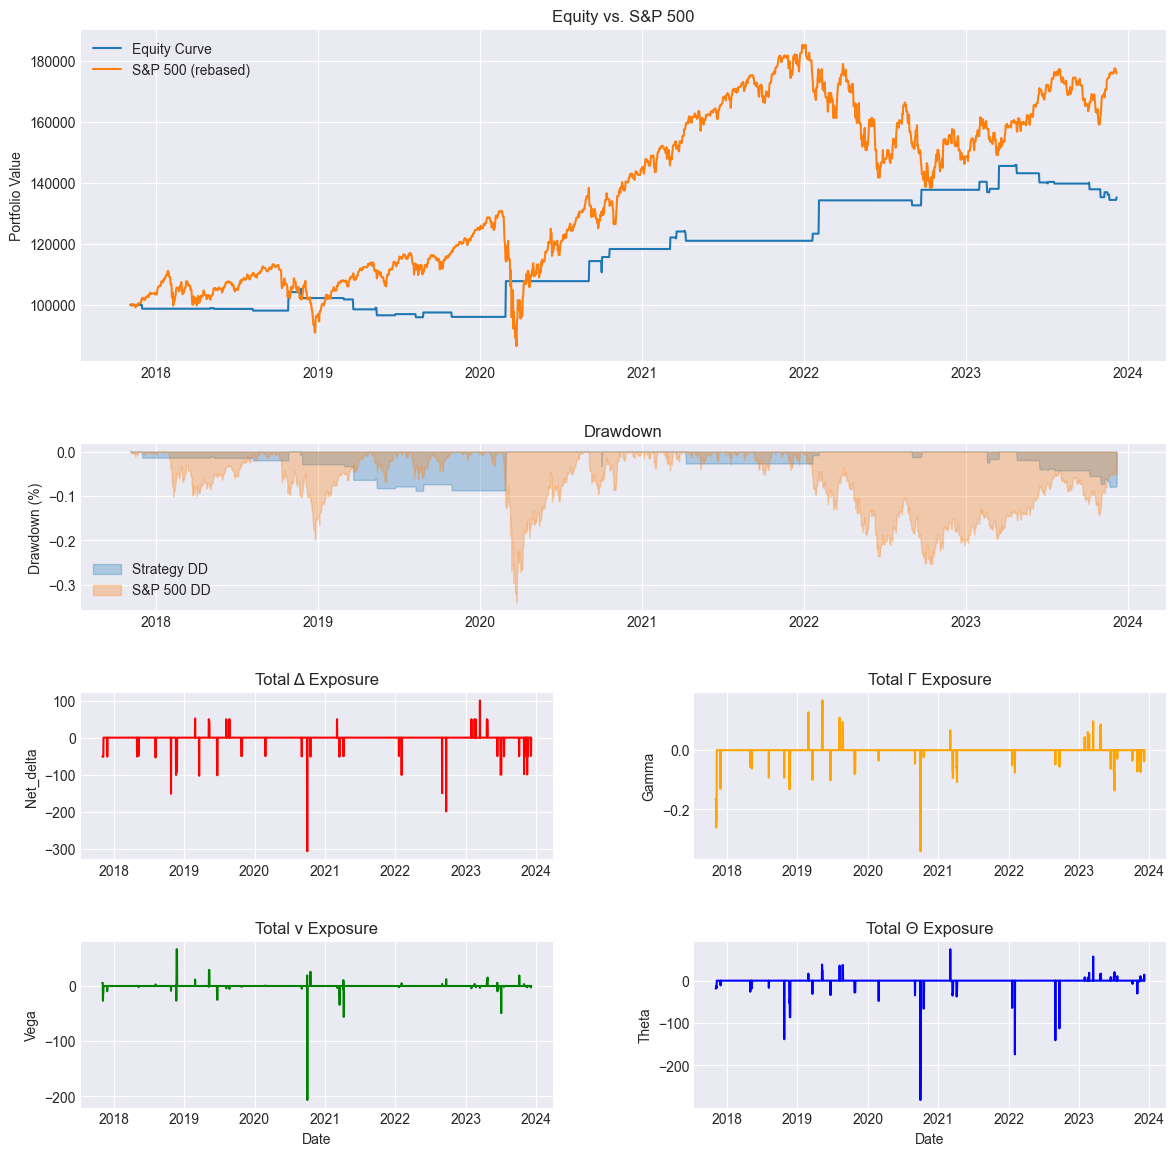

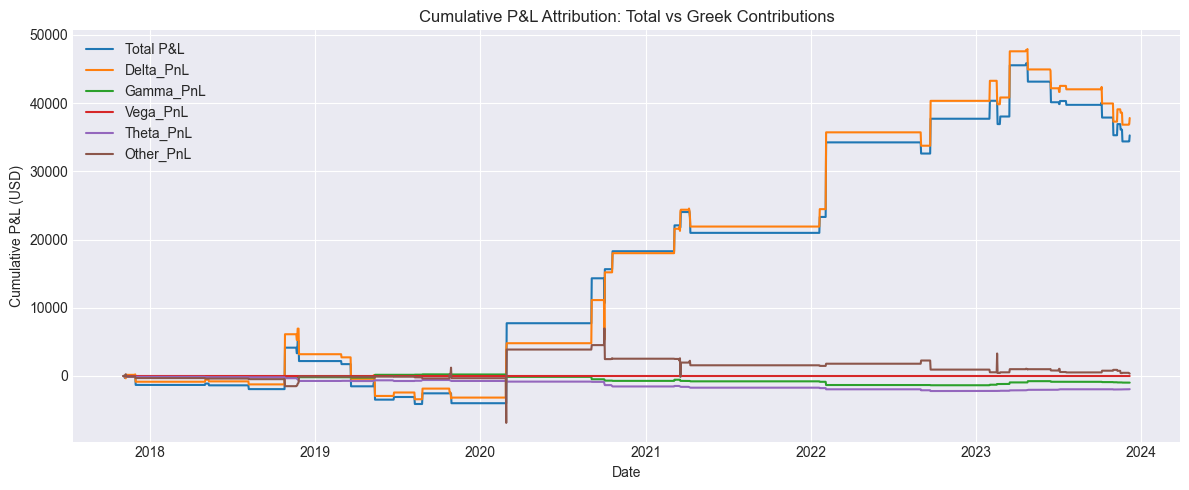

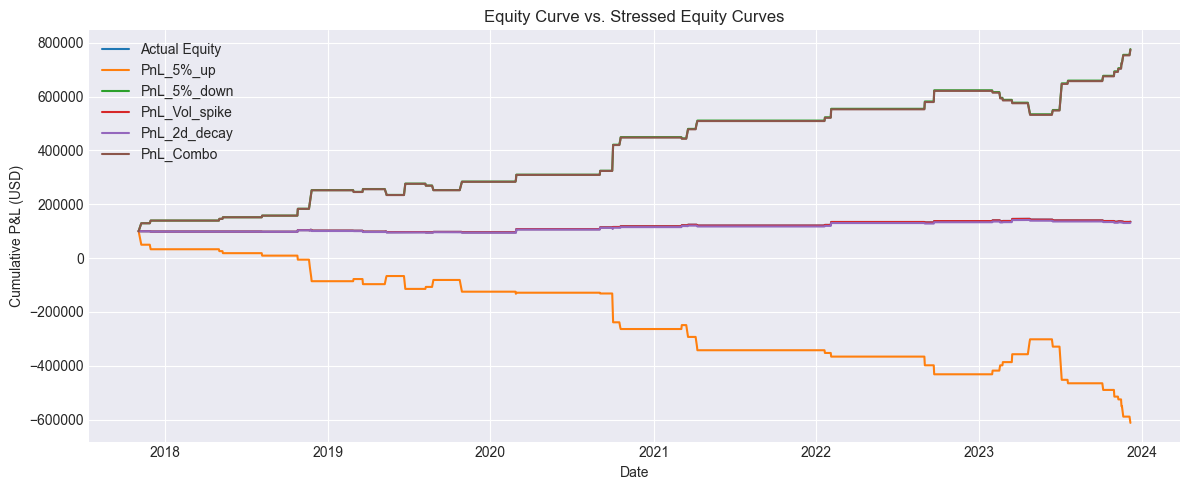

In [ ]:
bt = Backtester(
    options, synthetic_skew, vix, hedge_series,
    z_score_strategy, filters, hybrid_sizer,
    find_viable_dtes,
    stop_loss_pct=stop_loss_pct, take_profit_pct=take_profit_pct, 
    hedge_size=10000
)
summary, trades, mtm, params = bt.walk_forward()
daily_mtm = bt.to_daily_mtm(mtm)

ph.print_perf_metrics(trades, daily_mtm)
ph.plot_full_performance(sp500, daily_mtm)
ph.plot_pnl_attribution(daily_mtm)

stressed_mtm = Backtester.stress_test(daily_mtm, scenarios)
ph.plot_stressed_pnl(stressed_mtm, daily_mtm, scenarios)

### **With Delta Hedging**

🔍 Overall Performance Metrics
Sharpe Ratio           : 0.46
CAGR                   : 4.03%
Max Drawdown           : -8.58%
Max Drawdown Duration  : 685 days
Historical VaR (99%)   : -0.15%
Historical CVaR (99%)  : -1.33%
Total P&L              : $29,533.01
Profit Factor          : 2.40
Trade Frequency (ann.) : 6.1 trades/year
Total Trades           : 37
Win Rate               : 56.76%
Average Win P&L        : $2,409.38
Average Loss P&L       : $-1,316.50

📊 Performance by Contract Size
           win_rate  num_trades  total_win_pnl  total_loss_pnl  total_pnl
contracts                                                                
1              0.48          27       37985.01        -18449.0    19536.0
2              0.71           7        4740.00         -2615.0     2125.0
3              1.00           2        3467.00             0.0     3467.0
6              1.00           1        4405.00             0.0     4405.0



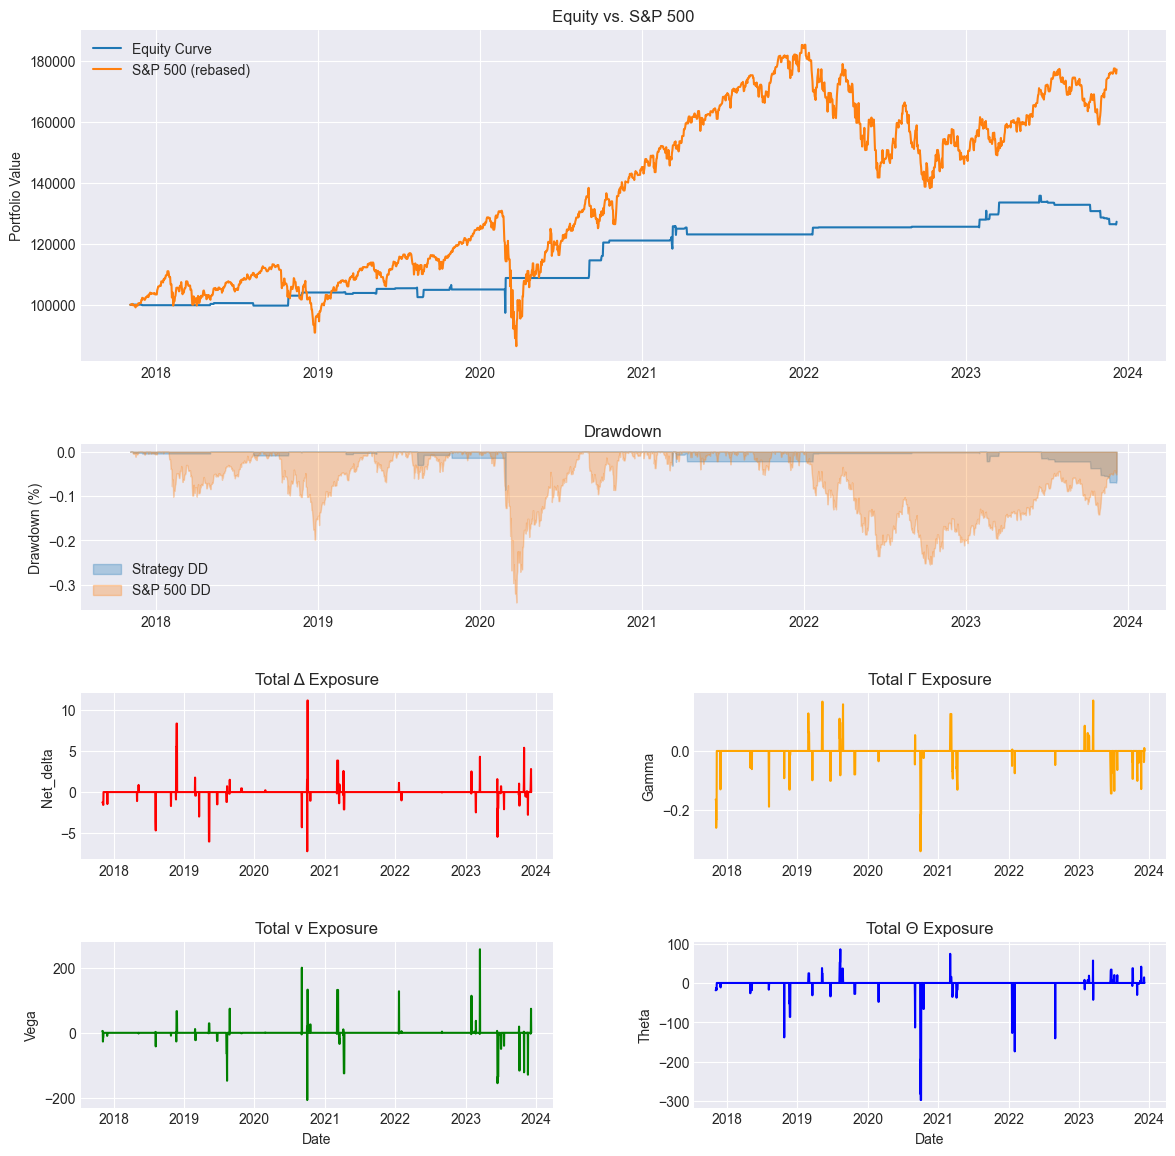

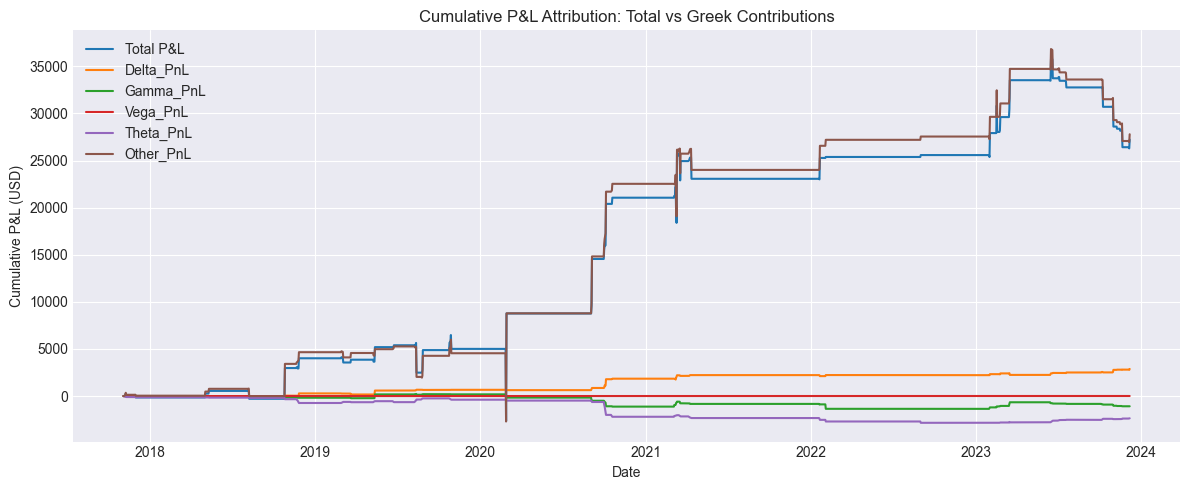

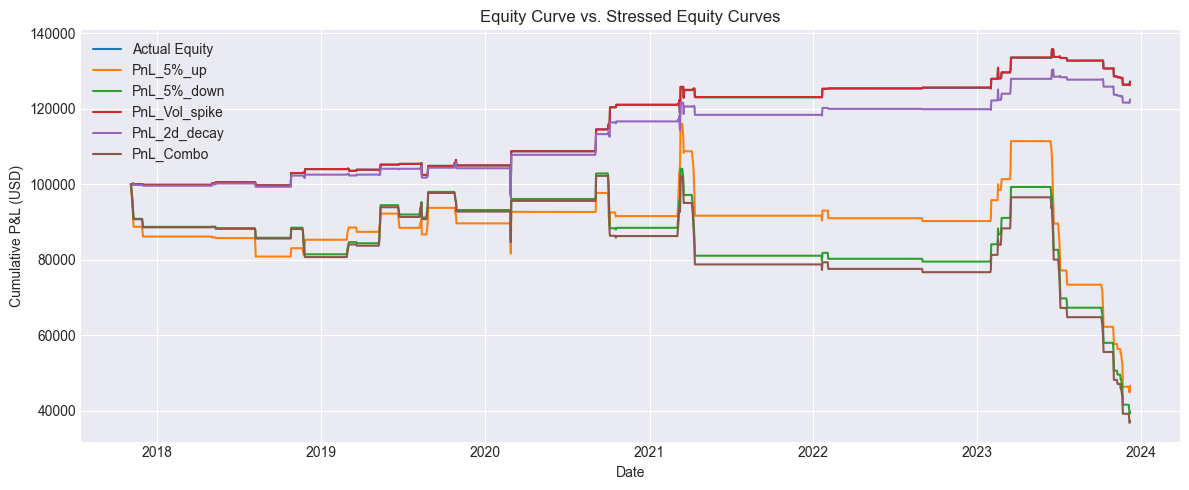

In [ ]:
bt = Backtester(
    options, synthetic_skew, vix, hedge_series,
    z_score_strategy, filters, hybrid_sizer,
    find_viable_dtes,
    stop_loss_pct=stop_loss_pct, take_profit_pct=take_profit_pct, 
    hedge_size=50
)
summary, trades, mtm, params = bt.walk_forward()
daily_mtm = bt.to_daily_mtm(mtm)

ph.print_perf_metrics(trades, daily_mtm)
ph.plot_full_performance(sp500, daily_mtm)
ph.plot_pnl_attribution(daily_mtm)

stressed_mtm = Backtester.stress_test(daily_mtm, scenarios)
ph.plot_stressed_pnl(stressed_mtm, daily_mtm, scenarios)

## **With Cross-Validation for the Z-score Signal parameters**

🔍 Overall Performance Metrics
Sharpe Ratio           : 0.51
CAGR                   : 8.42%
Max Drawdown           : -15.81%
Max Drawdown Duration  : 287 days
Historical VaR (99%)   : -0.81%
Historical CVaR (99%)  : -2.75%
Total P&L              : $67,535.51
Profit Factor          : 2.66
Trade Frequency (ann.) : 9.7 trades/year
Total Trades           : 57
Win Rate               : 61.40%
Average Win P&L        : $3,089.87
Average Loss P&L       : $-1,845.91

📊 Performance by Contract Size
           win_rate  num_trades  total_win_pnl  total_loss_pnl  total_pnl
contracts                                                                
1              0.48          29       16938.50        -23098.5   -6160.00
2              0.81          16       54130.00         -8345.0   45785.00
3              0.60           5        7012.51         -3080.5    3932.01
4              0.50           4        4624.00         -6086.0   -1462.00
5              1.00           1        7878.00             0.0  

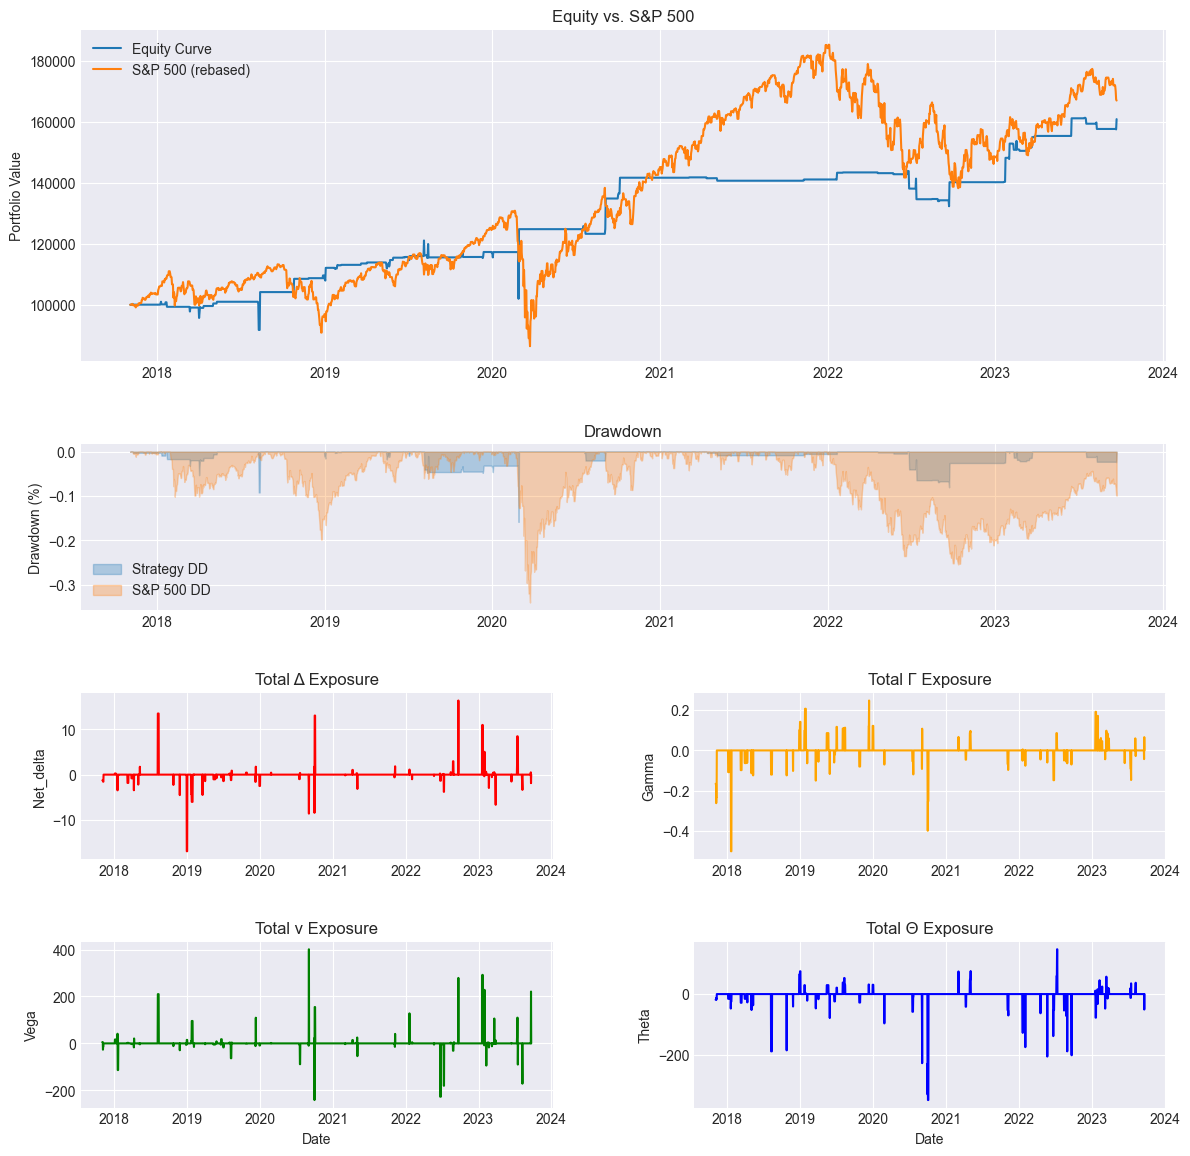

In [ ]:
params_grid = {
    "strategy__window": [21, 42, 63],
    "strategy__entry": [1.5, 2, 2.5]
}

bt = Backtester(
    options, synthetic_skew, vix, hedge_series,
    z_score_strategy, filters, hybrid_sizer,
    find_viable_dtes, params_grid=params_grid,
    stop_loss_pct=stop_loss_pct, take_profit_pct=take_profit_pct, 
    hedge_size=50
)
summary, trades, mtm, params = bt.walk_forward()
daily_mtm = bt.to_daily_mtm(mtm)

ph.print_perf_metrics(trades, daily_mtm)
ph.plot_full_performance(sp500, daily_mtm)